<a href="https://colab.research.google.com/github/Laura9704/Fundamentos_MCD/blob/main/Modelo_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#libreria

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #gráficos
import matplotlib.dates as mdates
pd.set_option('display.max_columns', None)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
from math import sqrt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,Dropout, Dense # Se usa SimpleRNN o la capa RNN que elijas
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Importa librerías para imputación
from scipy.interpolate import interp1d

import random
import os
import warnings
warnings.filterwarnings('ignore')

## Cargar desde Kaggle

In [2]:
from google.colab import files
files.upload()


Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"svlauracarolinasv","key":"2d7513d4cd31b4367dc2a650087afced"}'}

In [3]:
import sys
!mkdir -p ~/.kaggle
!mv "kaggle (1).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
import zipfile
# --- PASO 1: Descargar y Descomprimir ---
competition_name = 'fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn'
zip_file_name = f'{competition_name}.zip'

print(f"1. Descargando datos de la competición: {competition_name}...")
# El comando !kaggle descarga el archivo ZIP. El flag -p /content/ lo coloca en la raíz.
!kaggle competitions download -c {competition_name} -p /content/

# Descomprimir el archivo ZIP
print(f"2. Descomprimiendo archivos...")
try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Extraer todo el contenido a la carpeta actual (/content/)
        zip_ref.extractall('/content/')
    print("Descompresión completada. Archivos Parquet listos.")
except FileNotFoundError:
    print(f"\n[ERROR] No se encontró el archivo ZIP: {zip_file_name}")
    print("Asegúrate de que la descarga fue exitosa.")
    exit()

# --- PASO 2: Cargar df_train y df_test usando pd.read_parquet ---
try:
    # Cargar el set de entrenamiento
    df_train = pd.read_parquet('df_train.parquet')
    print(f"\n3. df_train cargado (Parquet). Shape: {df_train.shape}")

    # Cargar el set de prueba (test)
    df_test = pd.read_parquet('df_test.parquet')
    print(f"   df_test cargado (Parquet). Shape: {df_test.shape}")

except Exception as e:
    print("\n[ERROR] No se pudieron cargar 'df_train.parquet' o 'df_test.parquet'.")
    print(f"Detalle del error: {e}")

1. Descargando datos de la competición: fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn...
  0% 0.00/163k [00:00<?, ?B/s]
100% 163k/163k [00:00<00:00, 344MB/s]
2. Descomprimiendo archivos...
Descompresión completada. Archivos Parquet listos.

3. df_train cargado (Parquet). Shape: (8932, 10)
   df_test cargado (Parquet). Shape: (184, 9)


In [4]:
df_train.head()

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation
0,2000-01-01,20.1,23.1,27.5,57.0,77.0,95.0,308.1,2.8,0.0
1,2000-01-02,19.2,22.0,26.7,58.0,82.0,98.0,343.1,4.1,0.0
2,2000-01-03,18.0,21.7,28.8,51.0,80.0,98.0,456.1,4.5,2.1
3,2000-01-04,17.8,21.9,27.1,50.0,74.0,90.0,391.5,3.8,0.0
4,2000-01-05,19.0,22.3,27.4,51.0,76.0,95.0,348.4,3.9,0.0


In [5]:
df_train.isnull().sum()

,0
date,0
min_temp,56
avg_temp,57
max_temp,54
min_rel_humidity,94
avg_rel_humidity,92
max_rel_humidity,51
solar_radiation,88
evapotranspiration,1000
precipitation,0


In [6]:
df_test.head()

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration
0,2024-07-01,17.4,23.4,31.1,49.0,83.0,100.0,529.7,4.3
1,2024-07-02,20.2,23.7,29.8,61.0,85.0,100.0,396.5,3.3
2,2024-07-03,20.9,23.7,30.1,55.0,86.0,100.0,359.3,3.0
3,2024-07-04,19.5,22.7,28.9,63.0,91.0,100.0,304.8,2.4
4,2024-07-05,18.8,20.8,24.4,76.0,96.0,100.0,241.0,1.9


In [7]:
df_test.isnull().sum()

,0
date,0
min_temp,0
avg_temp,0
max_temp,0
min_rel_humidity,0
avg_rel_humidity,0
max_rel_humidity,0
solar_radiation,0
evapotranspiration,0


In [8]:
df=df_train.copy()

In [9]:
# Crear columna con el año
df["year"] = df["date"].dt.year

In [10]:
df.head()

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year
0,2000-01-01,20.1,23.1,27.5,57.0,77.0,95.0,308.1,2.8,0.0,2000
1,2000-01-02,19.2,22.0,26.7,58.0,82.0,98.0,343.1,4.1,0.0,2000
2,2000-01-03,18.0,21.7,28.8,51.0,80.0,98.0,456.1,4.5,2.1,2000
3,2000-01-04,17.8,21.9,27.1,50.0,74.0,90.0,391.5,3.8,0.0,2000
4,2000-01-05,19.0,22.3,27.4,51.0,76.0,95.0,348.4,3.9,0.0,2000


## CARGA DE ARCHIVOS DESDE DRIVE

In [11]:
'''
# CARGAR df_train.parquet
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/MCD/MCD_FDA_II/TALLER 2_RNN/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_train.parquet'
df = pd.read_parquet(file_path)
'''

"\n# CARGAR df_train.parquet\nimport pandas as pd\nfrom google.colab import drive\ndrive.mount('/content/drive')\nfile_path = '/content/drive/My Drive/MCD/MCD_FDA_II/TALLER 2_RNN/fa-ii-2025-ii-pronosticos-nn-rnn-lstm-tcn/df_train.parquet'\ndf = pd.read_parquet(file_path)\n"

# Imputacion del DATA

Diferencias entre imputación por media estacional e interpolación

**1. Imputación por estacionaliladad**

  *  **Qué hace:** Reemplaza valores faltantes con el promedio de valores observados en la misma estación/período (por ejemplo, todos los eneros, o todos los lunes, o la misma semana del año)
  *  **Supuesto:** Los datos tienen patrones estacionales recurrentes y el valor faltante debería parecerse al comportamiento típico de ese período
  *  **Resultado:** Introduce un valor "promedio" o "típico" que no considera la tendencia local ni los valores inmediatamente adyacentes
  *  **Ventaja:** Preserva patrones estacionales y es útil cuando hay ciclos claros (temperatura, ventas navideñas)
  *  **Desventaja:** Ignora la continuidad temporal local; puede crear saltos bruscos si el período actual es atípico

**2. Interpolación**

  *  **Qué hace:** Estima valores faltantes basándose en los valores observados más cercanos en el tiempo (anterior y posterior)
  *  **Supuesto:** Existe continuidad temporal y el valor faltante debería ser una transición suave entre sus vecinos
  *  **Métodos comunes:** Lineal (línea recta entre puntos), spline (curva suave), polinomial y time
  *  **Resultado:** Crea una transición continua que respeta la tendencia local
  *  **Ventaja:** Mantiene la continuidad de la serie y refleja mejor cambios graduales o tendencias
  *  **Desventaja:** No considera patrones estacionales; puede fallar si hay cambios abruptos reales



##Forma 1: Combinadondo
en esta imputacion toma en cuanta el largo de los huecos dentro de las variables del Data, que son mayores a 4 toma el de estacionalidad.

In [12]:
# -------------------------------
# FUNCIONES
# -------------------------------

def mask_long_nan_blocks(series, min_len=4):
    """
    Devuelve una máscara booleana para los NaN consecutivos con longitud mínima `min_len`.
    """
    is_nan = series.isna()
    mask = pd.Series(False, index=series.index)
    count = 0
    for i in range(len(series)):
        if is_nan.iloc[i]:
            count += 1
        else:
            if count >= min_len:
                mask.iloc[i - count:i] = True
            count = 0
    # Para el final de la serie
    if count >= min_len:
        mask.iloc[len(series) - count:] = True
    return mask

# -------------------------------
# Index de dates
# -------------------------------

df = df.set_index('date')
df.index = pd.to_datetime(df.index)

# -------------------------------
# VARIABLES A PROCESAR
# -------------------------------

columns_to_process = [
    'avg_temp', 'max_temp', 'min_temp',
    'avg_rel_humidity', 'max_rel_humidity', 'min_rel_humidity',
    'solar_radiation', 'evapotranspiration'
]

# Crear columna auxiliar: día del año (1-365)
df['dayofyear'] = df.index.dayofyear

# Definir un umbral superior basado en el conocimiento del dominio.
# Si 6999 es claramente un error, podemos usar un umbral conservador (e.g., 20)
UMBRAL_SUPERIOR = 20

# Reemplazar el valor atípico (outlier) con NaN
# Esto es esencial antes de la imputación estacional
df.loc[df['evapotranspiration'] > UMBRAL_SUPERIOR, 'evapotranspiration'] = None # Usamos 'None' o np.nan

print(f"Valores de evapotranspiration > {UMBRAL_SUPERIOR} han sido convertidos a NaN.")

# -------------------------------
# IMPUTACIÓN HÍBRIDA
# -------------------------------

for col in columns_to_process:
    series = df[col].copy()

    # 1. Identificar bloques largos
    long_nan_mask = mask_long_nan_blocks(series, min_len=4)

    # 2. Interpolación para bloques cortos
    series[~long_nan_mask] = series[~long_nan_mask].interpolate(limit=3, limit_direction='both')

    # 3. Estacionalidad por día del año para los valores restantes
    if series.isna().sum() > 0:
        series = series.fillna(df.groupby('dayofyear')[col].transform('mean'))

    # Reasignar al DataFrame original
    df[col] = series

# Eliminar columna auxiliar
df.drop(columns='dayofyear', inplace=True)

# -------------------------------
# REVISIÓN FINAL
# -------------------------------

print("Valores faltantes después de imputación:")
print(df[columns_to_process].isna().sum())


Valores de evapotranspiration > 20 han sido convertidos a NaN.
Valores faltantes después de imputación:
avg_temp              0
max_temp              0
min_temp              0
avg_rel_humidity      0
max_rel_humidity      0
min_rel_humidity      0
solar_radiation       0
evapotranspiration    0
dtype: int64


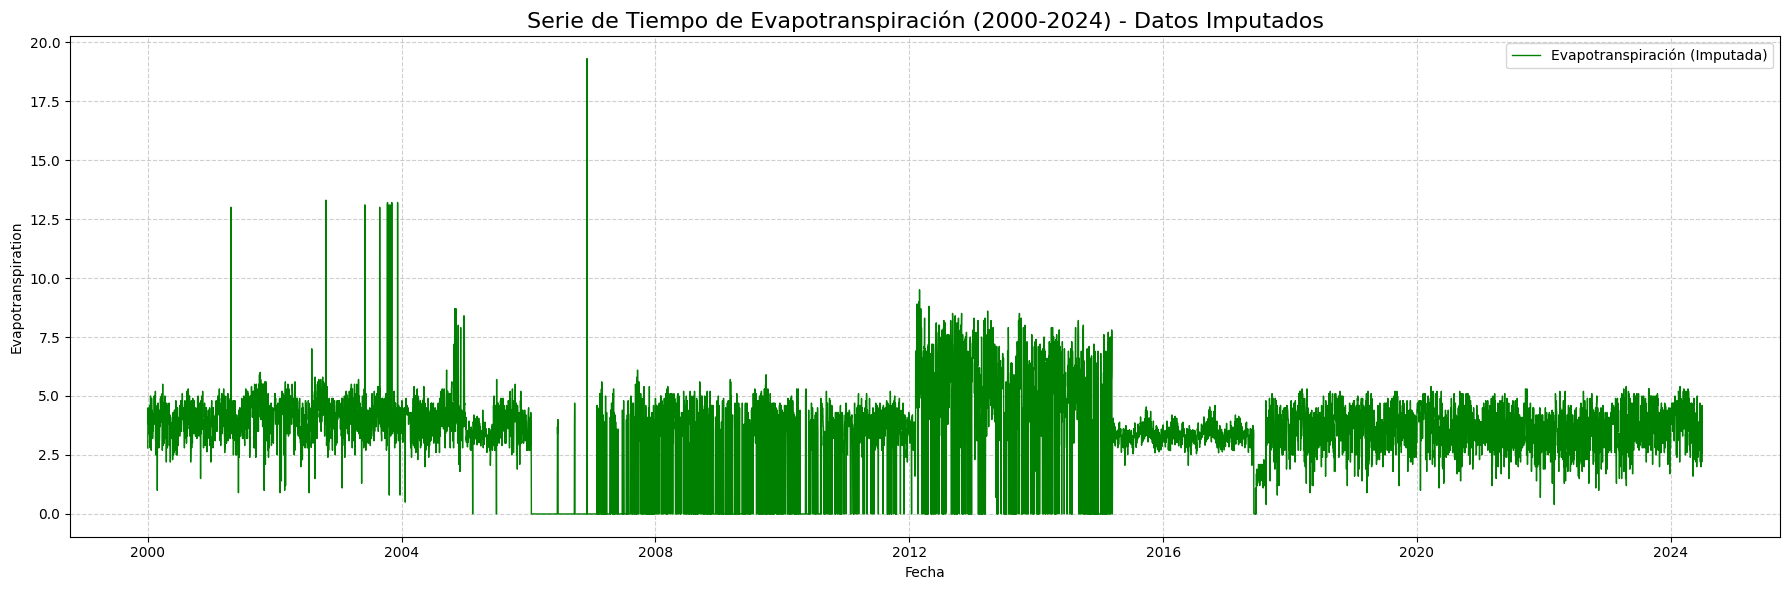


--- Verificación en la Brecha (2015-2018) ---


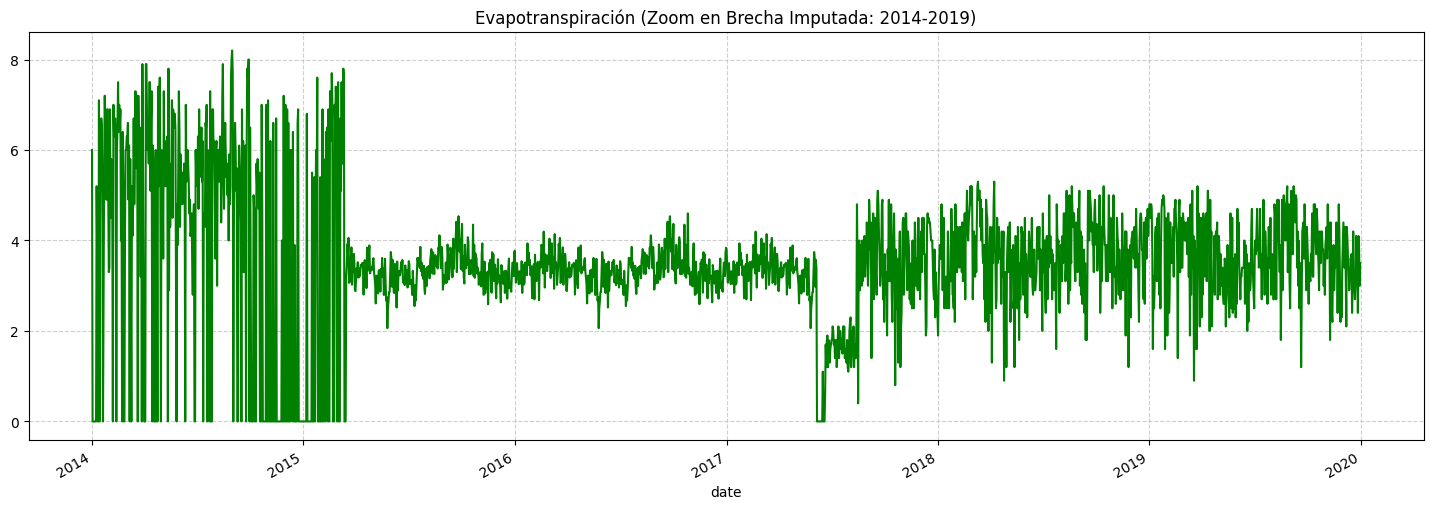

In [13]:
df_imputado=df.copy()
df=df_train.copy()
if not isinstance(df_imputado.index, pd.DatetimeIndex):
    # Esto es solo una verificación de seguridad si el índice no está configurado
    if 'date' in df_imputado.columns:
        df_imputado = df_imputado.set_index('date')
    df_imputado.index = pd.to_datetime(df_imputado.index)

# 2. Generar el gráfico
plt.figure(figsize=(18, 6))

# Grafica la serie completa. Ahora no habrá saltos ni NaN.
plt.plot(df_imputado.index,
         df_imputado['evapotranspiration'],
         color='green', # Usamos un color distinto para diferenciar de los gráficos originales
         linewidth=1.0,
         label='Evapotranspiración (Imputada)')

# 3. Formato y Título
plt.title("Serie de Tiempo de Evapotranspiración (2000-2024) - Datos Imputados", fontsize=16)
plt.xlabel("Fecha")
plt.ylabel("Evapotranspiration")
plt.legend(loc='upper right')
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# 4. (Opcional) Zoom para verificar la imputación en la zona 2015-2018
print("\n--- Verificación en la Brecha (2015-2018) ---")
plt.figure(figsize=(18, 6))
df_imputado.loc['2014':'2019', 'evapotranspiration'].plot(
    color='green', linewidth=1.5,
    title='Evapotranspiración (Zoom en Brecha Imputada: 2014-2019)'
)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [14]:
# Definir las fechas límite
start_date = '2015-04-16'
end_date = '2015-04-20'

# 1. Asegúrate de que la columna 'date' sea de tipo datetime
# df_train['date'] = pd.to_datetime(df_train['date'])

# 2. Filtrar usando la columna 'date'
df_periodo = df_train[
    (df_train['date'] >= start_date) &
    (df_train['date'] <= end_date)
].copy()
df_periodo

,date,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation
5568,2015-04-16,19.2,22.7,30.1,36.0,78.0,97.0,502.8,NaN,1.8
5569,2015-04-17,18.3,22.1,28.4,43.0,81.0,97.0,388.9,NaN,9.7
5570,2015-04-18,18.9,24.0,30.7,40.0,75.0,97.0,475.3,NaN,0.0
5571,2015-04-19,18.3,22.7,29.3,41.0,78.0,98.0,487.5,NaN,38.4
5572,2015-04-20,18.5,23.1,28.7,50.0,79.0,99.0,381.1,NaN,28.8


In [15]:
df_imputado = df_imputado.round(1)
df_imputado.loc['2015-04-16':'2015-04-20']

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year
date,,,,,,,,,,
2015-04-16,19.2,22.7,30.1,36.0,78.0,97.0,502.8,3.4,1.8,2015
2015-04-17,18.3,22.1,28.4,43.0,81.0,97.0,388.9,3.6,9.7,2015
2015-04-18,18.9,24.0,30.7,40.0,75.0,97.0,475.3,3.0,0.0,2015
2015-04-19,18.3,22.7,29.3,41.0,78.0,98.0,487.5,3.5,38.4,2015
2015-04-20,18.5,23.1,28.7,50.0,79.0,99.0,381.1,2.9,28.8,2015


#Simple RNN

##parametros

In [51]:
target_col='precipitation'
features_cols = [
    'avg_rel_humidity',
    'avg_temp',
    'evapotranspiration',
    'max_rel_humidity',
    'max_temp',
    'min_rel_humidity',
    'min_temp',
    'solar_radiation'
]

# Hiperparámetros del modelo
params = {
    'units': 128,         # Número de neuronas en la capa RNN
    'lr': 0.005,          # Tasa de aprendizaje
    'batch_size': 16,     # Tamaño de lote
    'epochs': 50,         # Número de épocas
    'drop_rate': 0.2,     # Dropout para regularización
    'loss_func':'huber_loss'
}

In [52]:
# ===============================================================
# Función para crear secuencias multivariables
# ===============================================================
def create_multivariate_sequences(data, target_col, n_steps=12):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data.iloc[i:i+n_steps].values)
        y.append(data[target_col].iloc[i+n_steps])
    return np.array(X), np.array(y)

Se desarrolló una función reutilizable para la preparación de datos, con el propósito de facilitar el proceso de modelado en diferentes etapas del análisis. Esta función permite ajustar de manera flexible las variables de entrada (features) y la variable objetivo (target), ya sea para incorporar nuevas variables derivadas —como medias móviles o indicadores acumulativos— o para reducir el conjunto de características según los requerimientos del modelo.

Además, la función estandariza las etapas de filtrado temporal, normalización y generación de secuencias, garantizando consistencia y evitando la fuga de información entre los conjuntos de entrenamiento y validación.

In [53]:
def preparar_datos_modelo(df,
                          features,
                          target_col,
                          n_steps=12,
                          train_range=('2000-01-01', '2023-12-31'),
                          val_range=('2024-01-01', '2024-06-30')):
    """
    Prepara los datos para el modelado de series temporales (multivariado o univariado).

    Permite agregar o eliminar variables, escalar sin fuga de información y crear
    las secuencias de entrada para modelos como LSTM, GRU, etc.

    Parámetros
    ----------
    df : pd.DataFrame
        DataFrame original con índice temporal.
    features : list
        Lista de columnas a usar como variables explicativas (X).
    target_col : str
        Columna objetivo a predecir (y).
    n_steps : int, opcional
        Tamaño de la ventana temporal (lookback). Por defecto 12.
    train_range : tuple
        Fechas de inicio y fin del conjunto de entrenamiento (formato 'YYYY-MM-DD').
    val_range : tuple
        Fechas de inicio y fin del conjunto de validación (formato 'YYYY-MM-DD').

    Retorna
    -------
    X_train, y_train, X_val, y_val : np.ndarray
        Conjuntos listos para el modelo.
    scaler : MinMaxScaler
        Escalador entrenado sobre el conjunto de entrenamiento.
    train_scaled, val_scaled : pd.DataFrame
        DataFrames escalados (para análisis o gráficos).
    """

    # --- 1️⃣ Asegurar formato temporal ---
    df_e = df.copy()
    df_e.index = pd.to_datetime(df_e.index)
    df_e = df_e.sort_index()

    # --- 2️⃣ Filtrar columnas seleccionadas ---
    df_e = df_e[features + [target_col]]

    # --- 3️⃣ Separar conjuntos de entrenamiento y validación ---
    train_df = df_e.loc[train_range[0]:train_range[1]]
    val_df = df_e.loc[val_range[0]:val_range[1]]

    # --- 4️⃣ Escalar solo con el entrenamiento ---
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df)
    val_scaled = scaler.transform(val_df)

    train_scaled = pd.DataFrame(train_scaled, index=train_df.index, columns=df_e.columns)
    val_scaled = pd.DataFrame(val_scaled, index=val_df.index, columns=df_e.columns)

    # --- 5️⃣ Crear secuencias ---
    X_train, y_train = create_multivariate_sequences(train_scaled, target_col, n_steps)
    X_val, y_val = create_multivariate_sequences(val_scaled, target_col, n_steps)

    # --- 6️⃣ Información resumida ---
    print(f"Ventana: {n_steps}")
    print(f"Entrenamiento: {X_train.shape}, {y_train.shape}")
    print(f"Validación:   {X_val.shape}, {y_val.shape}")

    return X_train, y_train, X_val, y_val, scaler, train_scaled, val_scaled


## Parámetros


Se implementó una red neuronal recurrente (RNN) utilizando la clase SimpleRNN de Keras, con el objetivo de pronosticar la precipitación diaria a partir de variables climáticas históricas. El conjunto de entrenamiento abarcó el período 01/01/2000–31/12/2023, mientras que los datos de 2024 se destinaron exclusivamente a validación. Para evitar fuga de información, el escalado se realizó únicamente sobre los datos de entrenamiento.

In [66]:
# ===============================================================
# SECCIÓN DE PARÁMETROS AJUSTABLES
# ===============================================================

target_col = 'precipitation'   # Variable objetivo
lookbacks = [5, 6, 7, 14, 21, 24, 30, 36]  # Ventanas temporales a probar

# Hiperparámetros del modelo
params = {
    'units': 128,         # Número de neuronas en la capa RNN
    'lr': 0.005,          # Tasa de aprendizaje
    'batch_size': 16,     # Tamaño de lote
    'epochs': 50,         # Número de épocas
    'drop_rate': 0.2    # Dropout para regularización
}

Se realizaron múltiples análisis con diferentes valores de lookback con el objetivo de identificar la ventana temporal que ofrece el mejor desempeño del modelo presentado a continuación. De acuerdo con los hallazgos del análisis exploratorio (EDA), se consideró que las ventanas cortas (entre 5 y 7 días) son más informativas y sensibles para capturar la variabilidad reciente de las precipitaciones. Cabe aclarar que en esta etapa se utilizaron únicamente las variables originales del conjunto de datos, previamente imputadas. Por tanto, esta sección busca determinar la longitud de ventana más adecuada para optimizar la capacidad predictiva del modelo RNN.

con respecto a los hirperparametros se seleccion como uma opcion que permite evaluar el comportamiento inicial de la red y servirán como referencia para futuros ajustes en busca de un mejor rendimiento

 * Número de neuronas: se seleccionó un valor intermedio que permita al modelo capturar patrones temporales sin que el número de parámetros sea excesivo para una primera iteración.

 * Tasa de aprendizaje: se seleccionó una tasa ligeramente superior al valor comúnmente utilizado (0.001) con el objetivo de acelerar la convergencia inicial y observar cómo responde el modelo a los primeros ajustes. Esta decisión permite evaluar si un aprendizaje más rápido mejora el desempeño sin comprometer la estabilidad del entrenamiento.

* Tamaño de lote: se definió un lote pequeño para mantener una actualización frecuente de los pesos y mejorar la estabilidad durante el entrenamiento inicial.

* Número de épocas: se estableció un número suficiente para analizar la tendencia del error sin extender innecesariamente el tiempo de cómputo.

* Dropout: se aplicó una regularización básica para prevenir sobreajuste y observar cómo el modelo generaliza desde las primeras pruebas.

##Modelo 1

In [64]:
# ===============================================================
# Función para entrenar y evaluar el modelo RNN
# ===============================================================
def train_rnn(
    X_train, y_train,
    X_val, y_val,
    n_steps, n_features,
    units=64,
    lr=0.001,
    batch_size=16,
    epochs=50,
    drop_rate=0.2,
    patience=10,
    verbose=0):

    """
    Entrena un modelo SimpleRNN y evalúa su rendimiento en el conjunto de validación.

    :param X_train: Datos de entrenamiento con forma (muestras, pasos, características).
    ...
    :return: mse, mae, rmse, r2, history, y_pred
    """

    # Definición del modelo
    model = Sequential([
        SimpleRNN(units, activation='tanh', input_shape=(n_steps, n_features)),
        Dropout(drop_rate),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    # Compilación del modelo
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mae',
        metrics=['mae', 'mse'])

    checkpoint = ModelCheckpoint(
    'best_rnn_model.keras', # O usa un nombre dinámico
    monitor='val_loss',
    save_best_only=True,
    mode='min')

    early_stop = EarlyStopping(
    monitor='val_loss', # Monitorea la pérdida de validación
    patience=patience,  # Espera 10 épocas sin mejora antes de detenerse
    restore_best_weights=True)

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop,checkpoint],
        verbose=verbose
        )

    #  Evaluación
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    return mse, mae, rmse, r2, history, y_pred


Para evaluar el desempeño del modelo RNN en la predicción de precipitaciones diarias, se decidio implementar diversas métricas que permiten analizar tanto la precisión como la estabilidad del modelo desde diferentes perspectivas:

* Error cuadrático medio (MSE): mide el promedio del cuadrado de los errores entre los valores reales y los predichos. Penaliza fuertemente los errores grandes, por lo que es útil para identificar desviaciones significativas en las predicciones.

* Error absoluto medio (MAE): calcula la magnitud promedio de los errores sin considerar su dirección. Es más interpretable que el MSE, ya que refleja directamente la desviación media del modelo respecto a los valores reales.

* Raíz del error cuadrático medio (RMSE): se obtiene al aplicar la raíz cuadrada del MSE. Esta métrica tiene las mismas unidades que la variable objetivo (precipitación), lo que facilita la interpretación física de los resultados.

* Coeficiente de determinación (R²): cuantifica la proporción de la variabilidad de los datos reales que es explicada por el modelo. Un valor cercano a 1 indica un buen ajuste y capacidad predictiva.

In [67]:
# ===============================================================
# Entrenamiento con diferentes ventanas temporales
# ===============================================================
results = []
histories = {}
predictions_dict = {}

for n_steps in lookbacks:
    print(f"Entrenando con lookback = {n_steps} días...")

    X_train, y_train = create_multivariate_sequences(train_scaled, target_col, n_steps)
    X_val, y_val = create_multivariate_sequences(val_scaled, target_col, n_steps)
    n_features = X_train.shape[2] # aquí se obtiene directamente del array

    mse, mae, rmse, r2, history, y_pred  = train_rnn(
        X_train, y_train, X_val, y_val,
        n_steps, n_features,
        **params   # ← usa los parámetros definidos arriba
    )

    results.append({
        'Lookback': n_steps,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

    histories[n_steps] = history
    predictions_dict[n_steps] = pd.DataFrame({
        'Real': y_val.flatten(),
        'Predicho': y_pred.flatten()
    })
    print(f"{n_steps} →→ RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R²={r2:.4f}")



Entrenando con lookback = 5 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5 →→ RMSE=0.088702, MSE=0.007868, MAE=0.032399, R²=-0.1511
Entrenando con lookback = 6 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6 →→ RMSE=0.089032, MSE=0.007927, MAE=0.032535, R²=-0.1541
Entrenando con lookback = 7 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
7 →→ RMSE=0.089138, MSE=0.007946, MAE=0.032810, R²=-0.1513
Entrenando con lookback = 14 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
14 →→ RMSE=0.091128, MSE=0.008304, MAE=0.033946, R²=-0.1611
Entrenando con lookback = 21 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
21 →→ RMSE=0.093000, MSE=0.008649, MAE=0.035409, R²=-0.1671
Entrenando con lookback = 24 días...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
24 →→ RMSE=0.093932, MSE=0.008823, MAE=0.036055, R²=-0.1722
Entrenando con lookback = 30 días...
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
30 →→ RMSE=0.093951, MSE=0.008827, MAE=0.036022, R²=-0.1696
Entrenando con lookback = 36 días...
5/5 ━━━━━━━━━━━━━━━━━━━━


Comparación de resultados por ventana temporal:
   Lookback       MSE       MAE      RMSE        R²
0         5  0.007868  0.032399  0.088702 -0.151084
1         6  0.007927  0.032535  0.089032 -0.154119
2         7  0.007946  0.032810  0.089138 -0.151309
3        14  0.008304  0.033946  0.091128 -0.161122
4        21  0.008649  0.035409  0.093000 -0.167086
5        24  0.008823  0.036055  0.093932 -0.172174
6        30  0.008827  0.036022  0.093951 -0.169584
7        36  0.005729  0.029375  0.075689 -0.177337


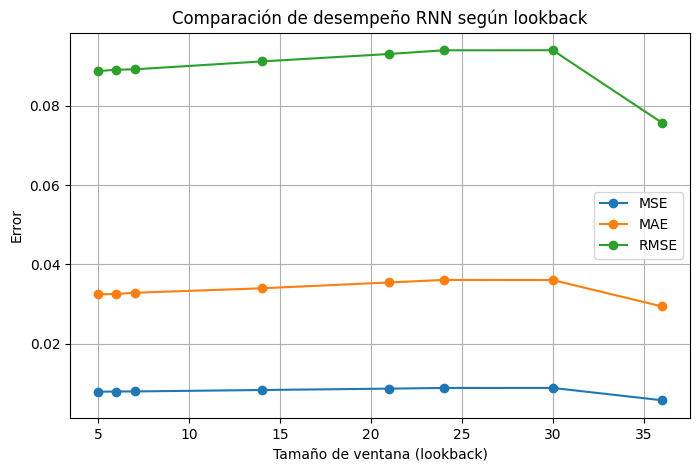

In [68]:
# ===============================================================
#  Visualización de resultados
# ===============================================================
# Tabla comparativa
results_df = pd.DataFrame(results)
print("\nComparación de resultados por ventana temporal:")
print(results_df)

# --- Gráfico comparativo de errores
plt.figure(figsize=(8, 5))
plt.plot(results_df['Lookback'], results_df['MSE'], marker='o', label='MSE')
plt.plot(results_df['Lookback'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['Lookback'], results_df['RMSE'], marker='o', label='RMSE')
plt.xlabel('Tamaño de ventana (lookback)')
plt.ylabel('Error')
plt.title('Comparación de desempeño RNN según lookback')
plt.legend()
plt.grid(True)
plt.show()

En general al evaluar los lookback en el modelo actual el que mejor desempeño nos referencia que la ventana de 36 dias para capturar los cambios del modelo, es decir que los resultados muestran que las ventanas más cortas (6–12 días) capturan mejor la variabilidad inmediata de la precipitación, mientras que las más largas (24–36 días) permiten representar patrones de acumulación y persistencia.

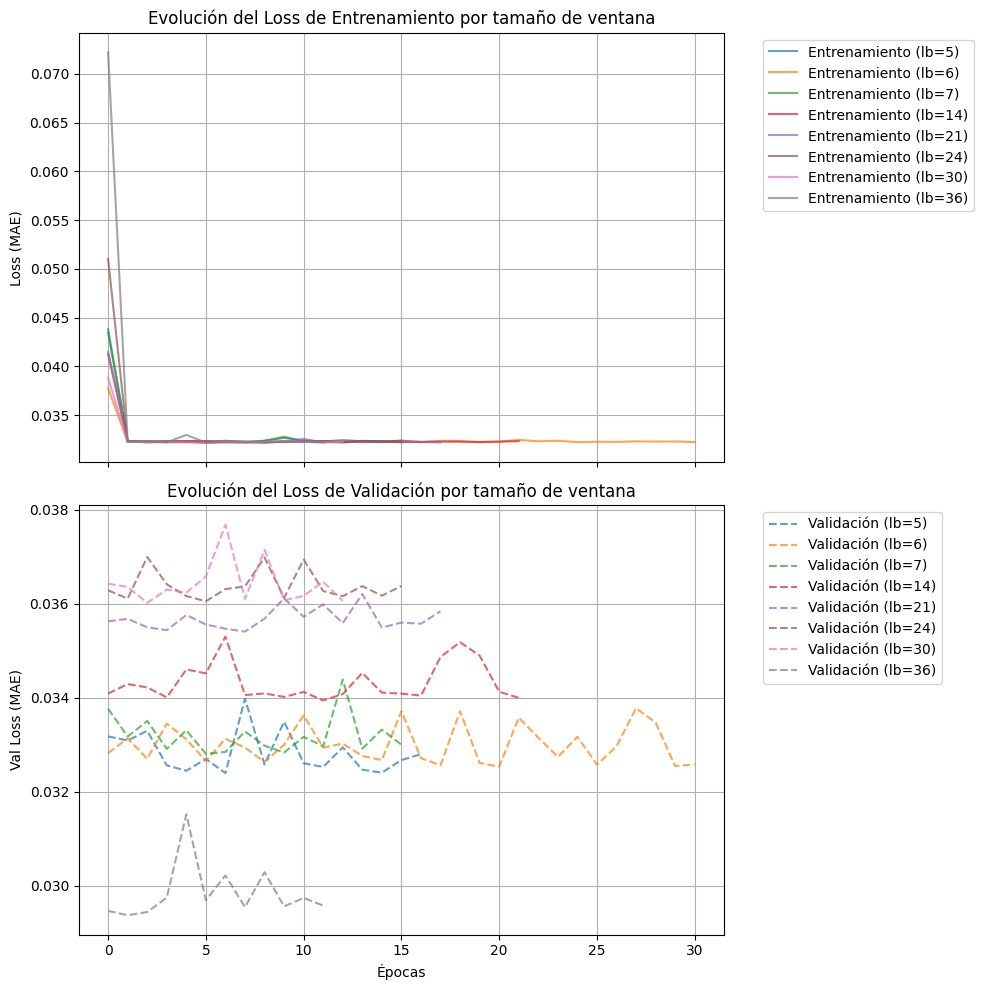

In [69]:
# ===============================================================
#  Gráfico de evolución del Loss (Train y Validación)
# ===============================================================
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- Train Loss
for n_steps, history in histories.items():
    axes[0].plot(history.history['loss'], label=f'Entrenamiento (lb={n_steps})', alpha=0.7)
axes[0].set_title('Evolución del Loss de Entrenamiento por tamaño de ventana')
axes[0].set_ylabel('Loss (MAE)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# --- Validation Loss
for n_steps, history in histories.items():
    axes[1].plot(history.history['val_loss'], linestyle='--', label=f'Validación (lb={n_steps})', alpha=0.7)
axes[1].set_title('Evolución del Loss de Validación por tamaño de ventana')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Val Loss (MAE)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()


Con el primer grafico se observa que los modelos entrenados presentan una rapida convergencia en sus primeras epocas, donde se estabiliza lo que indica que logra identificar ciertos patrones

en el segundo se observa que el modelo en si tiene oportunides de mejora, ya que se ve osilaciones con pocos cambios, en la observcion de todos ellos el que tiene menor cambio de sus curvas es la ventana de 36 dias.


 Mejor modelo: Lookback = 36 días

Primeras 10 comparaciones de valores reales vs predichos:
   Real  Predicho
0   0.0 -0.000054
1   0.0 -0.000054
2   0.0 -0.000054
3   0.0 -0.000054
4   0.0 -0.000054
5   0.0 -0.000054
6   0.0 -0.000054
7   0.0 -0.000054
8   0.0 -0.000054
9   0.0 -0.000054


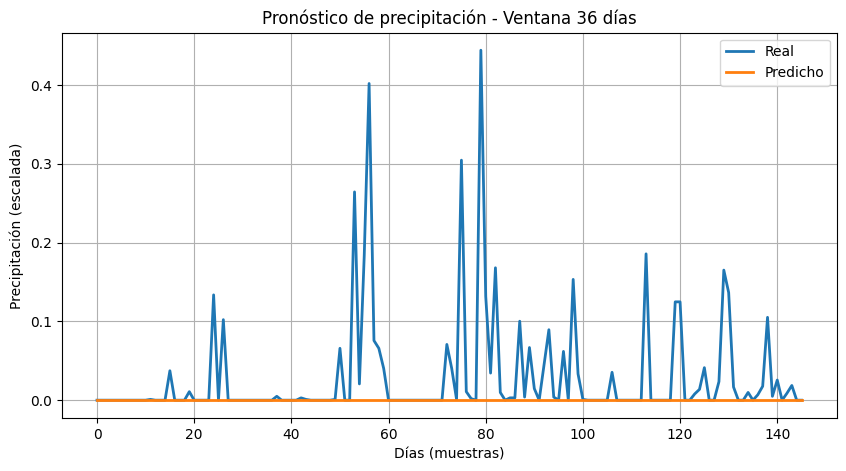

In [70]:
# ==============================
# Comparar predicciones del mejor modelo
# ==============================
best_lookback = results_df.loc[results_df['RMSE'].idxmin(), 'Lookback']
print(f"\n Mejor modelo: Lookback = {best_lookback} días")

pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
print(pred_df.head(10))

plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

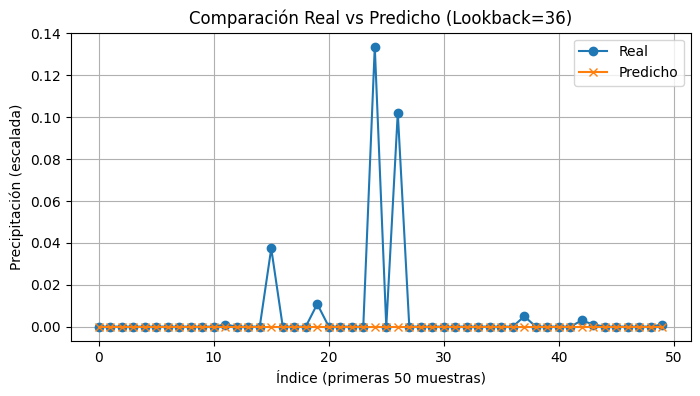

In [71]:
plt.figure(figsize=(8, 4))
plt.plot(pred_df['Real'][:50].values, label='Real', marker='o')
plt.plot(pred_df['Predicho'][:50].values, label='Predicho', marker='x')
plt.title(f'Comparación Real vs Predicho (Lookback={best_lookback})')
plt.xlabel('Índice (primeras 50 muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

Sin embargo, los resultados del modelo indican que estas ventanas no presentan la mejor distribución, debido a que las precipitaciones diarias contienen una gran cantidad de valores cero. Esto sugiere la necesidad de capturar las tendencias de acumulación o persistencia en la variable objetivo (target).

Por ello, se ajustará el modelo para incluir una variable basada en la media móvil, con el fin de representar mejor estas dinámicas temporales.

## Modelo 2

In [ ]:
target_col = 'precipitation'   # Variable objetivo
lookbacks = [5, 6, 7, 14, 21, 24, 30, 36]  # Ventanas temporales a probar

# Hiperparámetros del modelo
params = {
    'units': 128,         # Número de neuronas en la capa RNN
    'lr': 0.005,          # Tasa de aprendizaje
    'batch_size': 16,     # Tamaño de lote
    'epochs': 50,         # Número de épocas
    'drop_rate': 0.2,     # Dropout para regularización
    'loss_func':'huber'
}

In [58]:
# ===============================================================
# Función para entrenar y evaluar el modelo RNN
# ===============================================================
def train_rnn(
    X_train, y_train,
    X_val, y_val,
    n_steps, n_features,
    units=64,
    lr=0.001,
    batch_size=16,
    epochs=50,
    drop_rate=0.2,
    loss_func=('loss', 'mse'),
    patience=10,
    verbose=0):

    """
    Entrena un modelo SimpleRNN y evalúa su rendimiento en el conjunto de validación.

    :param X_train: Datos de entrenamiento con forma (muestras, pasos, características).
    ...
    :return: mse, mae, rmse, r2, history, y_pred
    """

    # Definición del modelo
    model = Sequential([
        SimpleRNN(units, activation='relu', input_shape=(n_steps, n_features)),
        Dropout(drop_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # Compilación del modelo
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=loss_func,
        metrics=['mae', 'mse'])

    checkpoint = ModelCheckpoint(
    'best_rnn_model.keras', # O usa un nombre dinámico
    monitor='val_loss',
    save_best_only=True,
    mode='min')

    early_stop = EarlyStopping(
    monitor='val_loss', # Monitorea la pérdida de validación
    patience=patience,  # Espera 10 épocas sin mejora antes de detenerse
    restore_best_weights=True)

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop,checkpoint],
        verbose=verbose
        )

    #  Evaluación
    y_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    return mse, mae, rmse, r2, history, y_pred


In [59]:
# ===============================================================
# Entrenamiento con diferentes ventanas temporales
# ===============================================================
results = []
histories = {}
predictions_dict = {}

for n_steps in lookbacks:
    print(f"Entrenando con lookback = {n_steps} días...")

    X_train, y_train = create_multivariate_sequences(train_scaled, target_col, n_steps)
    X_val, y_val = create_multivariate_sequences(val_scaled, target_col, n_steps)
    n_features = X_train.shape[2] # aquí se obtiene directamente del array

    mse, mae, rmse, r2, history, y_pred  = train_rnn(
        X_train, y_train, X_val, y_val,
        n_steps, n_features,
        **params   # ← usa los parámetros definidos arriba
    )

    results.append({
        'Lookback': n_steps,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

    histories[n_steps] = history
    predictions_dict[n_steps] = pd.DataFrame({
        'Real': y_val.flatten(),
        'Predicho': y_pred.flatten()
    })
    print(f"{n_steps} →→ RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R²={r2:.4f}")



Entrenando con lookback = 5 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
5 →→ RMSE=0.080478, MSE=0.006477, MAE=0.048756, R²=0.0525
Entrenando con lookback = 6 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
6 →→ RMSE=0.080699, MSE=0.006512, MAE=0.048952, R²=0.0518
Entrenando con lookback = 7 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
7 →→ RMSE=0.081106, MSE=0.006578, MAE=0.047147, R²=0.0468
Entrenando con lookback = 14 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14 →→ RMSE=0.082471, MSE=0.006801, MAE=0.046785, R²=0.0490
Entrenando con lookback = 21 días...
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
21 →→ RMSE=0.084545, MSE=0.007148, MAE=0.049027, R²=0.0355
Entrenando con lookback = 24 días...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
24 →→ RMSE=0.085080, MSE=0.007239, MAE=0.050704, R²=0.0383
Entrenando con lookback = 30 días...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
30 →→ RMSE=0.084868, MSE=0.007203, MAE=0.051219, R²=0.0456
Entrenando con lookback = 36 días...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63m


Comparación de resultados por ventana temporal:
   Lookback       MSE       MAE      RMSE        R²
0         5  0.006477  0.048756  0.080478  0.052476
1         6  0.006512  0.048952  0.080699  0.051814
2         7  0.006578  0.047147  0.081106  0.046836
3        14  0.006801  0.046785  0.082471  0.049019
4        21  0.007148  0.049027  0.084545  0.035488
5        24  0.007239  0.050704  0.085080  0.038341
6        30  0.007203  0.051219  0.084868  0.045623
7        36  0.004632  0.041057  0.068062  0.047987


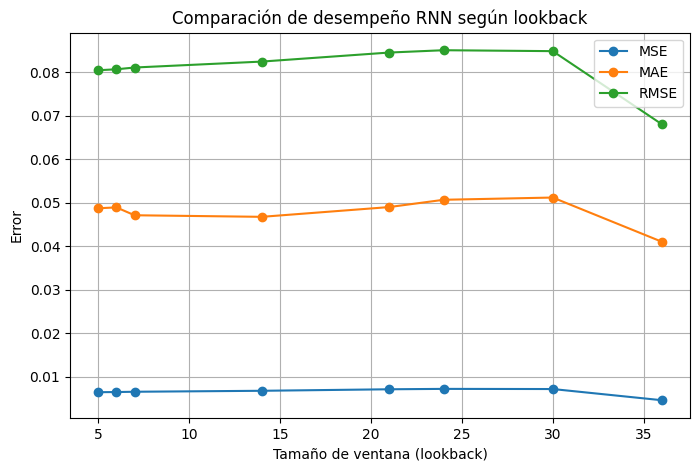

In [60]:
# ===============================================================
#  Visualización de resultados
# ===============================================================
# Tabla comparativa
results_df = pd.DataFrame(results)
print("\nComparación de resultados por ventana temporal:")
print(results_df)

# --- Gráfico comparativo de errores
plt.figure(figsize=(8, 5))
plt.plot(results_df['Lookback'], results_df['MSE'], marker='o', label='MSE')
plt.plot(results_df['Lookback'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['Lookback'], results_df['RMSE'], marker='o', label='RMSE')
plt.xlabel('Tamaño de ventana (lookback)')
plt.ylabel('Error')
plt.title('Comparación de desempeño RNN según lookback')
plt.legend()
plt.grid(True)
plt.show()

En general al evaluar los lookback en el nuevo modelo aun nos muestra que la mejor ventana es 36 para el lookback

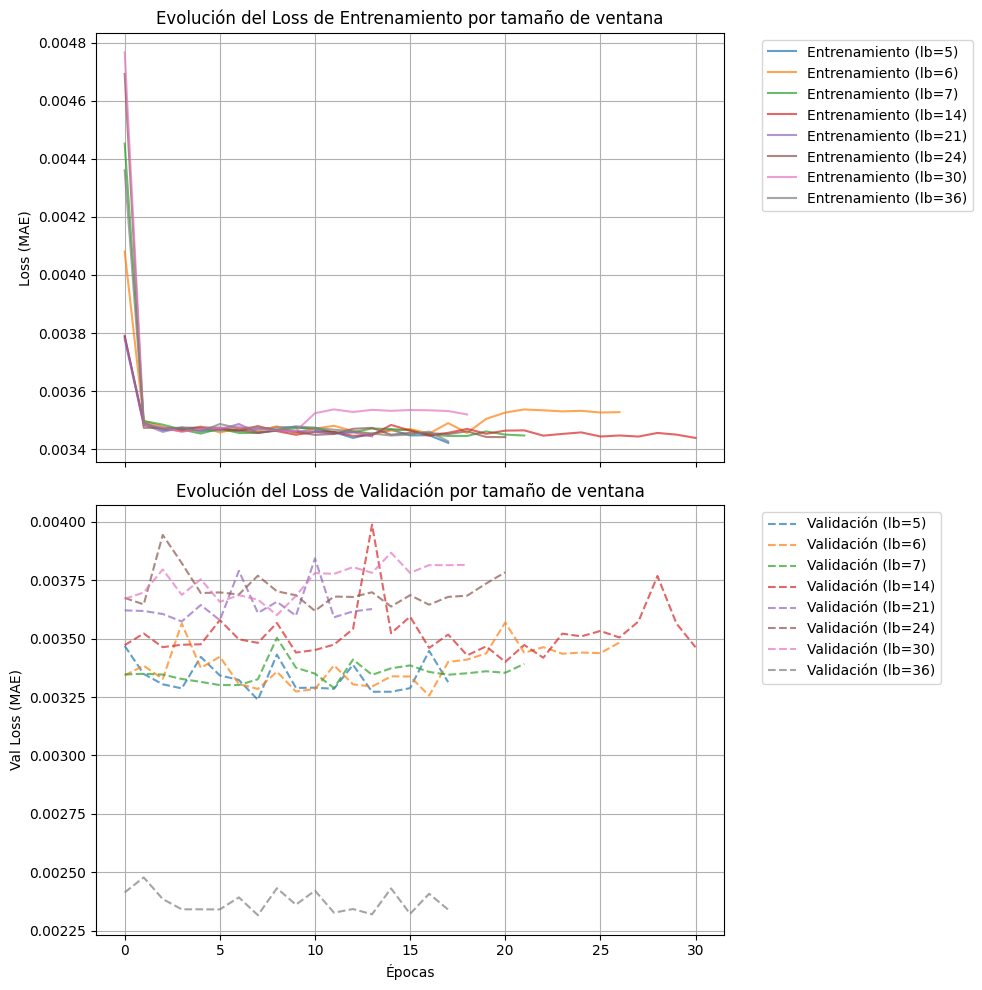

In [61]:
# ===============================================================
#  Gráfico de evolución del Loss (Train y Validación)
# ===============================================================
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- Train Loss
for n_steps, history in histories.items():
    axes[0].plot(history.history['loss'], label=f'Entrenamiento (lb={n_steps})', alpha=0.7)
axes[0].set_title('Evolución del Loss de Entrenamiento por tamaño de ventana')
axes[0].set_ylabel('Loss (MAE)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# --- Validation Loss
for n_steps, history in histories.items():
    axes[1].plot(history.history['val_loss'], linestyle='--', label=f'Validación (lb={n_steps})', alpha=0.7)
axes[1].set_title('Evolución del Loss de Validación por tamaño de ventana')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Val Loss (MAE)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()


En la gráfica de Evolución del Loss de Entrenamiento (MAE), se observa una convergencia extremadamente rápida, con una caída significativa de la función de pérdida en la primera época para todos los tamaños de lookback.

Posteriormente, la pérdida de entrenamiento se estabiliza en un valor bajo, lo que indica que el modelo ha alcanzado un ajuste efectivo a los datos de entrenamiento. La superposición de las curvas de loss de entrenamiento sugiere que el tamaño de la ventana (lookback) no tiene un impacto significativo en la capacidad intrínseca del modelo para aprender la relación en los datos de entrenamiento.

En contraste, la Evolución del Loss de Validación muestra un comportamiento volátil y fluctuante a lo largo de las épocas. Esta volatilidad es normal, pero las diferencias entre las curvas son más pronunciadas. Aunque las fluctuaciones indican la susceptibilidad al sobreajuste (especialmente si el Val Loss comienza a divergir del Training Loss), el lookback de 36 (línea gris) destaca por mantener consistentemente el valor de loss más bajo, lo que sugiere la mejor generalización a datos no vistos.




 Mejor modelo: Lookback = 36 días

Primeras 10 comparaciones de valores reales vs predichos:
   Real  Predicho
0   0.0  0.059299
1   0.0  0.052126
2   0.0  0.040035
3   0.0  0.041444
4   0.0  0.024716
5   0.0  0.020700
6   0.0  0.019143
7   0.0  0.018258
8   0.0  0.020329
9   0.0  0.017910


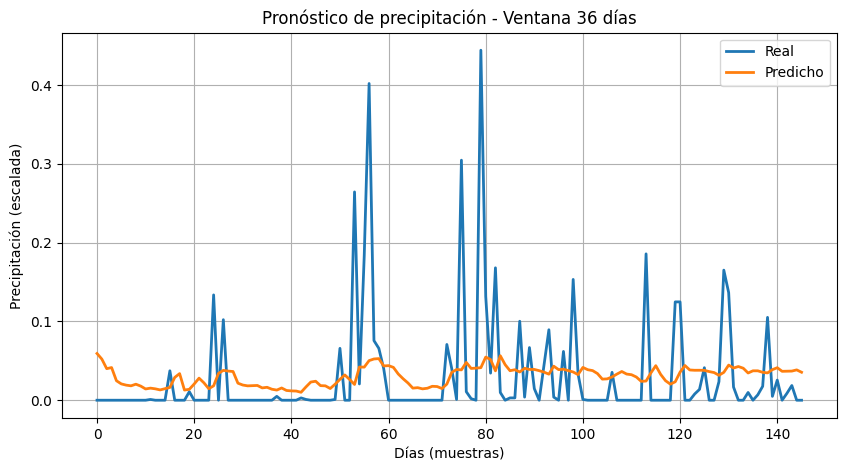

In [62]:
# ==============================
# Comparar predicciones del mejor modelo
# ==============================
best_lookback = results_df.loc[results_df['RMSE'].idxmin(), 'Lookback']
print(f"\n Mejor modelo: Lookback = {best_lookback} días")

pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
print(pred_df.head(10))

plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

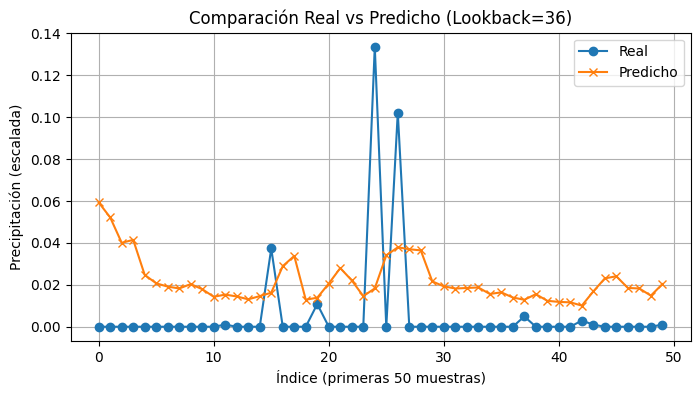

In [63]:
plt.figure(figsize=(8, 4))
plt.plot(pred_df['Real'][:50].values, label='Real', marker='o')
plt.plot(pred_df['Predicho'][:50].values, label='Predicho', marker='x')
plt.title(f'Comparación Real vs Predicho (Lookback={best_lookback})')
plt.xlabel('Índice (primeras 50 muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

Los resultados del modelo, tras aplicar cambios en la arquitectura (uso de ReLU y activación lineal en la capa de salida, junto con el ajuste de hiperparámetros con una funcion de perdido loss= huber), indican una mejora significativa en la captura del comportamiento de la serie temporal. El modelo ahora es capaz de reconocer y predecir los picos de precipitación, a pesar de que la serie contiene una gran cantidad de valores cero.

por lo cual se puede concluir que las modificaciones lograron desatascar el modelo del mínimo local trivial de la predicción constante. Ahora, el SimpleRNN es sensible a los cambios en la serie temporal.

## Modelo 3

In [83]:
target_col = 'precipitation'   # Variable objetivo
lookbacks = [5, 6, 7, 14, 21, 24, 30, 36]  # Ventanas temporales a probar

params = {
    'units': 128,
    'lr': 0.005,         # Valor intermedio: más estable que 0.005
    'batch_size': 16,
    'epochs': 50,
    'drop_rate': 0.2,
    'huber_delta': 0.15,  # <--- NUEVO: Sensibilidad de la Huber Loss (valor más bajo)
    'loss_func': 'huber', # Usaremos el objeto Huber
    'patience': 10
}

In [85]:
# === AÑADE ESTA IMPORTACIÓN ===
from tensorflow.keras.losses import Huber


# AÑADIMOS EL PARÁMETRO huber_delta
def train_rnn(
    X_train, y_train, X_val, y_val,
    n_steps, n_features,
    units=128,             # Subido a 128
    lr=0.003,              # Ajustado a 0.003
    batch_size=16,
    epochs=50,
    drop_rate=0.2,
    loss_func='mse',
    huber_delta=1.0,       # <--- VALOR POR DEFECTO DEL DELTA DE HUBER
    patience=10,
    verbose=0):

    # Definición del modelo (se mantiene SimpleRNN con la arquitectura mejorada)
    model = Sequential([
        # Usamos 128 units para más capacidad
        SimpleRNN(units,
                  activation='relu',
                  input_shape=(n_steps, n_features),
                  return_sequences=True),

        SimpleRNN(units // 2, # cambio
              activation='relu'),

        Dropout(drop_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # --- CAMBIO CLAVE: USO DE HUBER LOSS AJUSTABLE ---

    # 1. Definir la función de pérdida
    if loss_func.lower() == 'huber':
        # Usamos el objeto Huber y ajustamos el Delta.
        # Delta < 1.0 obliga a ser más preciso cerca del cero.
        loss_to_use = Huber(delta=huber_delta)
    else:
        # Usa la pérdida especificada (e.g., 'mse' o 'mae')
        loss_to_use = loss_func

    # 2. Compilación del modelo
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=loss_to_use,
        metrics=['mae', 'mse'])

    checkpoint = ModelCheckpoint(
        'best_rnn_model.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min')

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True)

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=verbose
        )

    # Evaluación
    y_pred = model.predict(X_val, verbose=0)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    return mse, mae, rmse, r2, history, y_pred

In [86]:
# ===============================================================
# Entrenamiento con diferentes ventanas temporales
# ===============================================================
results = []
histories = {}
predictions_dict = {}

for n_steps in lookbacks:
    print(f"Entrenando con lookback = {n_steps} días...")

    X_train, y_train = create_multivariate_sequences(train_scaled, target_col, n_steps)
    X_val, y_val = create_multivariate_sequences(val_scaled, target_col, n_steps)
    n_features = X_train.shape[2] # aquí se obtiene directamente del array

    mse, mae, rmse, r2, history, y_pred  = train_rnn(
        X_train, y_train, X_val, y_val,
        n_steps, n_features,
        **params   # ← usa los parámetros definidos arriba
    )

    results.append({
        'Lookback': n_steps,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

    histories[n_steps] = history
    predictions_dict[n_steps] = pd.DataFrame({
        'Real': y_val.flatten(),
        'Predicho': y_pred.flatten()
    })
    print(f"{n_steps} →→ RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R²={r2:.4f}")



Entrenando con lookback = 5 días...
5 →→ RMSE=0.081813, MSE=0.006693, MAE=0.040811, R²=0.0208
Entrenando con lookback = 6 días...
6 →→ RMSE=0.081290, MSE=0.006608, MAE=0.041671, R²=0.0379
Entrenando con lookback = 7 días...
7 →→ RMSE=0.081965, MSE=0.006718, MAE=0.041155, R²=0.0265
Entrenando con lookback = 14 días...
14 →→ RMSE=0.083653, MSE=0.006998, MAE=0.041279, R²=0.0215
Entrenando con lookback = 21 días...
21 →→ RMSE=0.085034, MSE=0.007231, MAE=0.044688, R²=0.0243
Entrenando con lookback = 24 días...
24 →→ RMSE=0.086136, MSE=0.007419, MAE=0.044605, R²=0.0143
Entrenando con lookback = 30 días...
30 →→ RMSE=0.085443, MSE=0.007301, MAE=0.044606, R²=0.0326
Entrenando con lookback = 36 días...
36 →→ RMSE=0.067837, MSE=0.004602, MAE=0.037204, R²=0.0543



Comparación de resultados por ventana temporal:
   Lookback       MSE       MAE      RMSE        R²
0         5  0.006460  0.036491  0.080375  0.054895
1         6  0.006463  0.040736  0.080390  0.059054
2         7  0.006163  0.037487  0.078505  0.106979
3        14  0.006628  0.041436  0.081414  0.073219
4        21  0.006738  0.043622  0.082082  0.090848
5        24  0.007033  0.042364  0.083863  0.065667
6        30  0.007239  0.042568  0.085082  0.040810
7        36  0.004658  0.036650  0.068246  0.042830


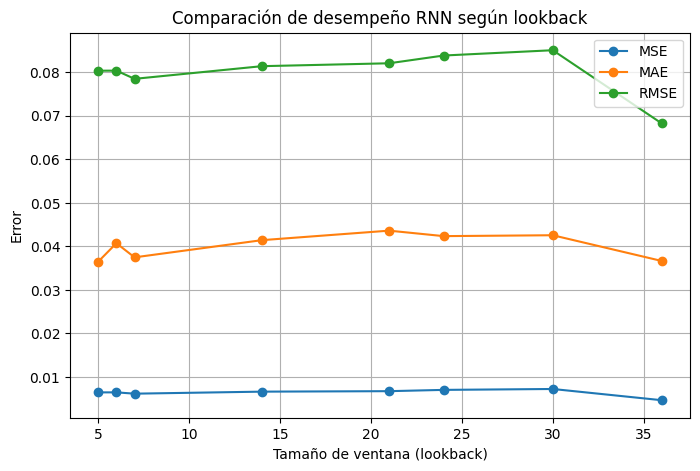

In [100]:
# ===============================================================
#  Visualización de resultados
# ===============================================================
# Tabla comparativa
results_df = pd.DataFrame(results)
print("\nComparación de resultados por ventana temporal:")
print(results_df)

# --- Gráfico comparativo de errores
plt.figure(figsize=(8, 5))
plt.plot(results_df['Lookback'], results_df['MSE'], marker='o', label='MSE')
plt.plot(results_df['Lookback'], results_df['MAE'], marker='o', label='MAE')
plt.plot(results_df['Lookback'], results_df['RMSE'], marker='o', label='RMSE')
plt.xlabel('Tamaño de ventana (lookback)')
plt.ylabel('Error')
plt.title('Comparación de desempeño RNN según lookback')
plt.legend()
plt.grid(True)
plt.show()

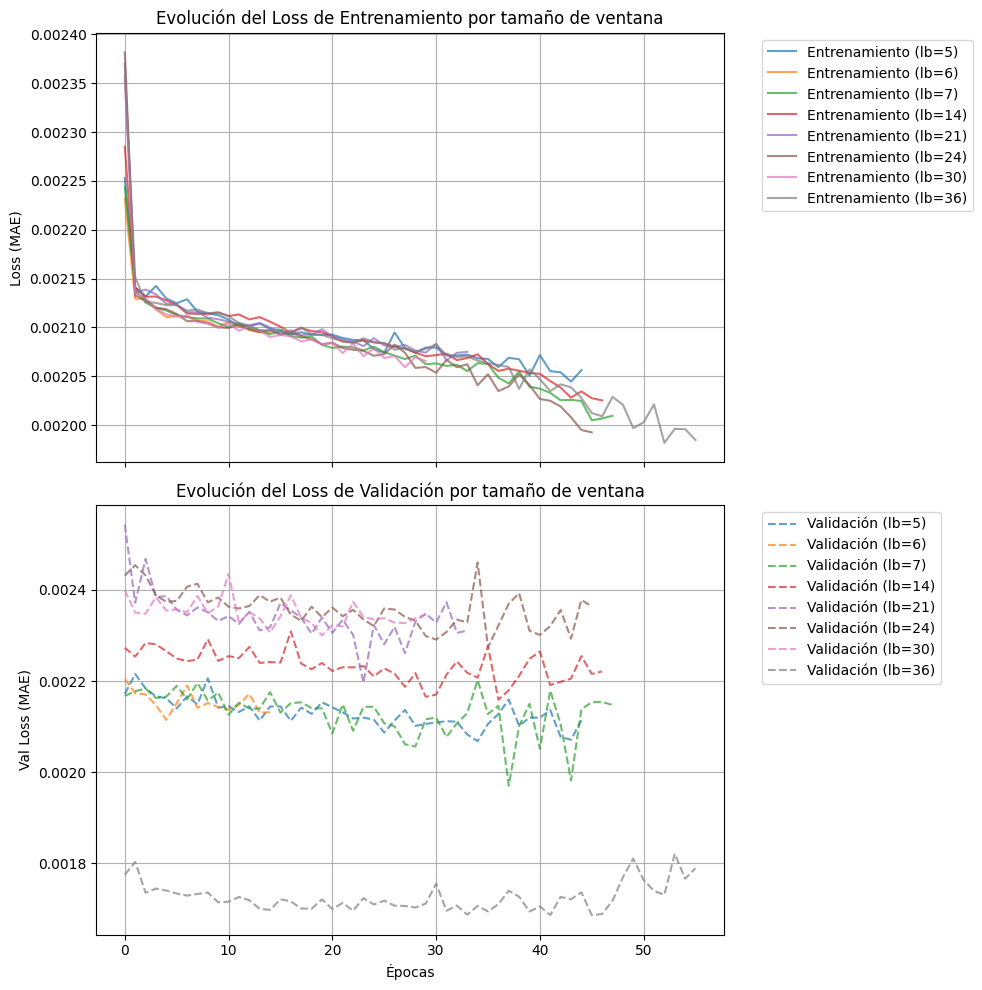

In [101]:
# ===============================================================
#  Gráfico de evolución del Loss (Train y Validación)
# ===============================================================
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- Train Loss
for n_steps, history in histories.items():
    axes[0].plot(history.history['loss'], label=f'Entrenamiento (lb={n_steps})', alpha=0.7)
axes[0].set_title('Evolución del Loss de Entrenamiento por tamaño de ventana')
axes[0].set_ylabel('Loss (MAE)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# --- Validation Loss
for n_steps, history in histories.items():
    axes[1].plot(history.history['val_loss'], linestyle='--', label=f'Validación (lb={n_steps})', alpha=0.7)
axes[1].set_title('Evolución del Loss de Validación por tamaño de ventana')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Val Loss (MAE)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()


 Mejor modelo: Lookback = 36 días

Primeras 10 comparaciones de valores reales vs predichos:
   Real  Predicho
0   0.0  0.037632
1   0.0  0.014080
2   0.0  0.018815
3   0.0  0.014915
4   0.0  0.015888
5   0.0  0.017621
6   0.0  0.021901
7   0.0  0.012022
8   0.0  0.012092
9   0.0  0.005710


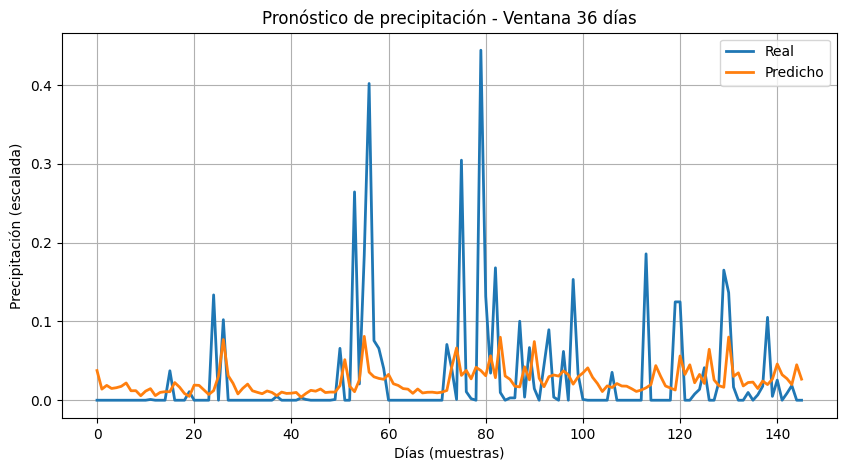

In [102]:
# ==============================
# Comparar predicciones del mejor modelo
# ==============================
best_lookback = results_df.loc[results_df['RMSE'].idxmin(), 'Lookback']
print(f"\n Mejor modelo: Lookback = {best_lookback} días")

pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
print(pred_df.head(10))

plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

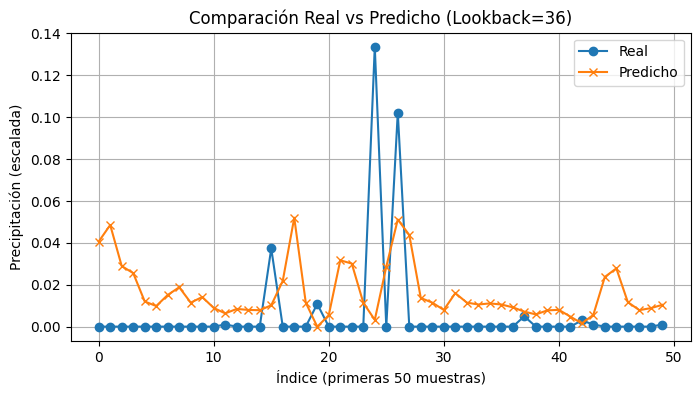

In [91]:
plt.figure(figsize=(8, 4))
plt.plot(pred_df['Real'][:50].values, label='Real', marker='o')
plt.plot(pred_df['Predicho'][:50].values, label='Predicho', marker='x')
plt.title(f'Comparación Real vs Predicho (Lookback={best_lookback})')
plt.xlabel('Índice (primeras 50 muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

Con las modificaciones del modelo de entrenamiento con una SimpleRNN aplida de 2 capaz y con el ajuste de delta_huber, puedo concluir que:

El modelo supero el estancamiento que tenia repecto a los ceros de la target, ya que tiene un mejor comportamiento al capturar el la estacionalidad y la tendencia de los picos, aunque aun tiene una persistencia en el reconociemento de las picos con valores mas grandes, es decir subestima la magnitud, esto es base al delta_huber.

### ajuste de hiperparametros

In [92]:
params = {
    'units': 128,
    'lr': 0.001,         # Valor intermedio: más estable que 0.005
    'batch_size': 16,
    'epochs': 70,
    'drop_rate': 0.2,
    'huber_delta': 0.12,  # <--- NUEVO: Sensibilidad de la Huber Loss (valor más bajo)
    'loss_func': 'huber', # Usaremos el objeto Huber
    'patience': 10
}

In [93]:
# ===============================================================
# Entrenamiento con diferentes ventanas temporales
# ===============================================================
results = []
histories = {}
predictions_dict = {}

for n_steps in lookbacks:
    print(f"Entrenando con lookback = {n_steps} días...")

    X_train, y_train = create_multivariate_sequences(train_scaled, target_col, n_steps)
    X_val, y_val = create_multivariate_sequences(val_scaled, target_col, n_steps)
    n_features = X_train.shape[2] # aquí se obtiene directamente del array

    mse, mae, rmse, r2, history, y_pred  = train_rnn(
        X_train, y_train, X_val, y_val,
        n_steps, n_features,
        **params   # ← usa los parámetros definidos arriba
    )

    results.append({
        'Lookback': n_steps,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

    histories[n_steps] = history
    predictions_dict[n_steps] = pd.DataFrame({
        'Real': y_val.flatten(),
        'Predicho': y_pred.flatten()
    })
    print(f"{n_steps} →→ RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R²={r2:.4f}")

Entrenando con lookback = 5 días...
5 →→ RMSE=0.080375, MSE=0.006460, MAE=0.036491, R²=0.0549
Entrenando con lookback = 6 días...
6 →→ RMSE=0.080390, MSE=0.006463, MAE=0.040736, R²=0.0591
Entrenando con lookback = 7 días...
7 →→ RMSE=0.078505, MSE=0.006163, MAE=0.037487, R²=0.1070
Entrenando con lookback = 14 días...
14 →→ RMSE=0.081414, MSE=0.006628, MAE=0.041436, R²=0.0732
Entrenando con lookback = 21 días...
21 →→ RMSE=0.082082, MSE=0.006738, MAE=0.043622, R²=0.0908
Entrenando con lookback = 24 días...
24 →→ RMSE=0.083863, MSE=0.007033, MAE=0.042364, R²=0.0657
Entrenando con lookback = 30 días...
30 →→ RMSE=0.085082, MSE=0.007239, MAE=0.042568, R²=0.0408
Entrenando con lookback = 36 días...
36 →→ RMSE=0.068246, MSE=0.004658, MAE=0.036650, R²=0.0428



Comparación de resultados por ventana temporal:
   Lookback       MSE       MAE      RMSE        R²
0         5  0.006460  0.036491  0.080375  0.054895
1         6  0.006463  0.040736  0.080390  0.059054
2         7  0.006163  0.037487  0.078505  0.106979
3        14  0.006628  0.041436  0.081414  0.073219
4        21  0.006738  0.043622  0.082082  0.090848
5        24  0.007033  0.042364  0.083863  0.065667
6        30  0.007239  0.042568  0.085082  0.040810
7        36  0.004658  0.036650  0.068246  0.042830

 Mejor modelo: Lookback = 36 días

Primeras 10 comparaciones de valores reales vs predichos:
   Real  Predicho
0   0.0  0.037632
1   0.0  0.014080
2   0.0  0.018815
3   0.0  0.014915
4   0.0  0.015888
5   0.0  0.017621
6   0.0  0.021901
7   0.0  0.012022
8   0.0  0.012092
9   0.0  0.005710


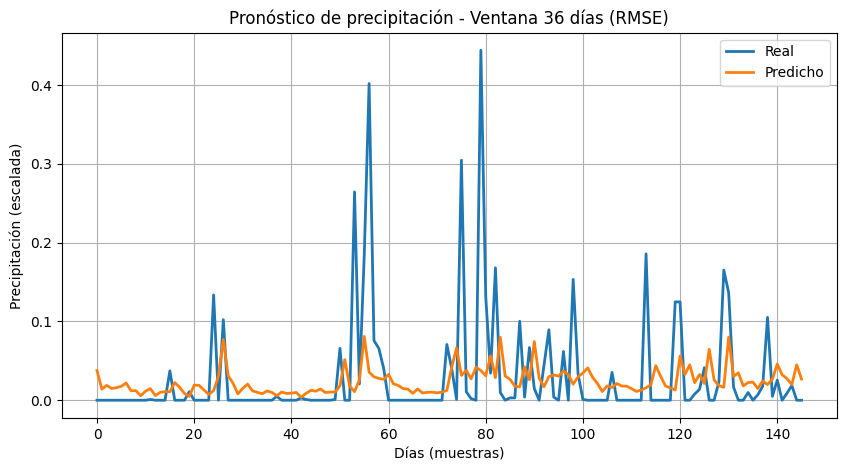

In [106]:
# ==============================
# Comparar predicciones del mejor modelo
# ==============================
# Tabla comparativa
results_df = pd.DataFrame(results)
print("\nComparación de resultados por ventana temporal:")
print(results_df)

best_lookback = results_df.loc[results_df['RMSE'].idxmin(), 'Lookback']
print(f"\n Mejor modelo: Lookback = {best_lookback} días")

pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
print(pred_df.head(10))

plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días (RMSE)')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()


 Mejor modelo: Lookback = 7 días

Primeras 10 comparaciones de valores reales vs predichos:
       Real  Predicho
0  0.000000  0.008470
1  0.012770  0.009378
2  0.000000  0.009709
3  0.000000  0.012431
4  0.000000  0.007975
5  0.017682  0.012599
6  0.000000  0.017568
7  0.000000  0.010222
8  0.000000  0.008554
9  0.000000  0.008149


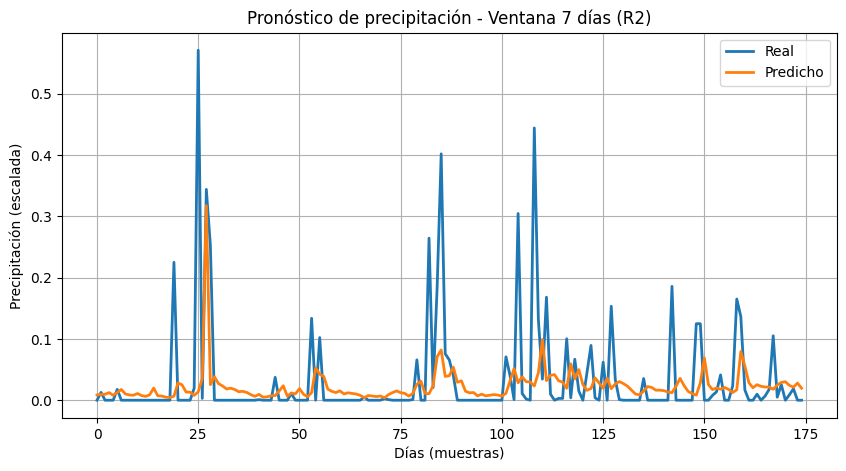

In [108]:
# ==============================
# Comparar predicciones del mejor modelo
# ==============================
best_lookback = results_df.loc[results_df['R²'].idxmax(), 'Lookback']
print(f"\n Mejor modelo: Lookback = {best_lookback} días")

pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
print(pred_df.head(10))

plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días (R2)')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

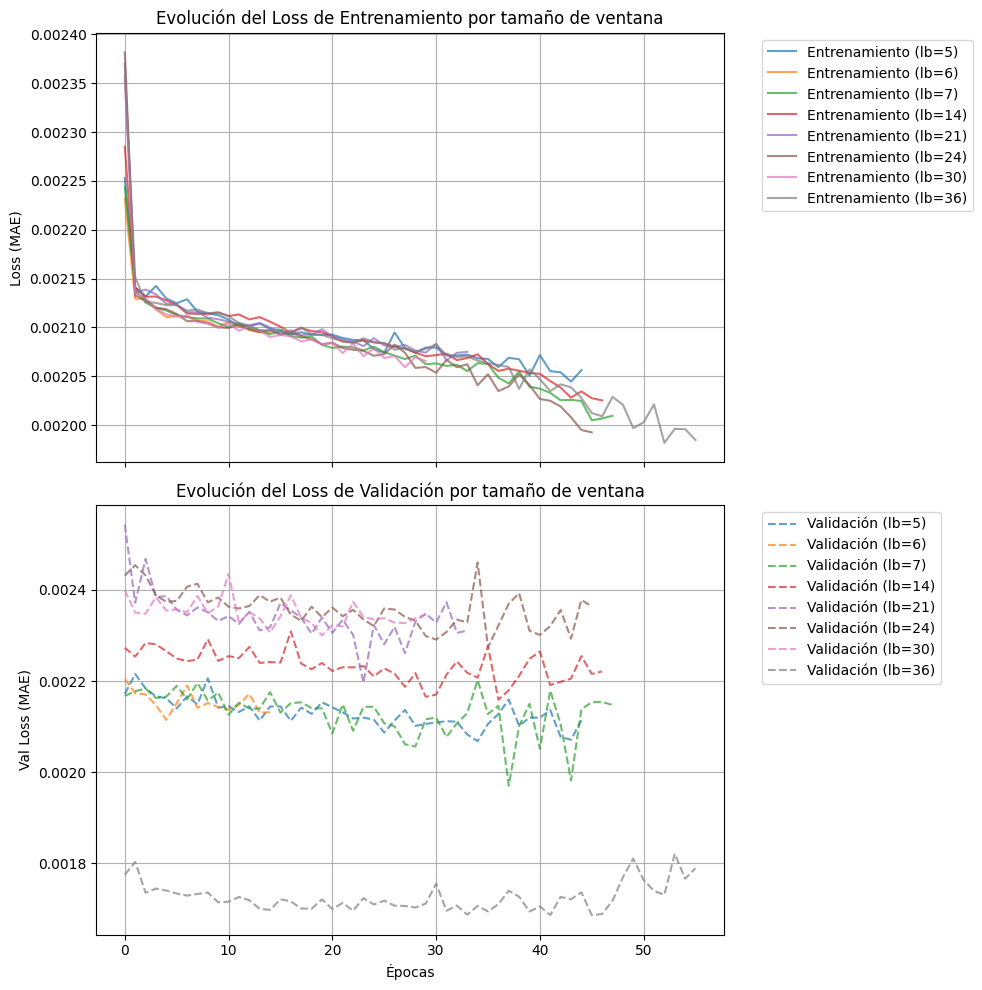

In [109]:
# ===============================================================
#  Gráfico de evolución del Loss (Train y Validación)
# ===============================================================
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# --- Train Loss
for n_steps, history in histories.items():
    axes[0].plot(history.history['loss'], label=f'Entrenamiento (lb={n_steps})', alpha=0.7)
axes[0].set_title('Evolución del Loss de Entrenamiento por tamaño de ventana')
axes[0].set_ylabel('Loss (MAE)')
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0].grid(True)

# --- Validation Loss
for n_steps, history in histories.items():
    axes[1].plot(history.history['val_loss'], linestyle='--', label=f'Validación (lb={n_steps})', alpha=0.7)
axes[1].set_title('Evolución del Loss de Validación por tamaño de ventana')
axes[1].set_xlabel('Épocas')
axes[1].set_ylabel('Val Loss (MAE)')
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].grid(True)

plt.tight_layout()
plt.show()

### ajuste de parametros y RNN

In [119]:
params = {
    'units': 128,              # Número de unidades (neuronas) en la 1ª capa RNN
    'lr': 0.001,               # Learning rate: velocidad a la que se ajustan los pesos
    'batch_size': 32,          # Tamaño de los lotes de entrenamiento
    'epochs': 70,              # Máximo de épocas de entrenamiento
    'drop_rate': 0.2,          # Tasa de dropout para evitar overfitting
    'huber_delta': 0.3,       # Delta de sensibilidad para la Huber loss
    'loss_func': 'huber',      # Tipo de función de pérdida: Huber
    'patience': 10             # Número de épocas sin mejora para activar EarlyStopping
}


In [120]:
# === AÑADE ESTA IMPORTACIÓN ===
from tensorflow.keras.losses import Huber


# AÑADIMOS EL PARÁMETRO huber_delta
def train_rnn(
    X_train, y_train, X_val, y_val,
    n_steps, n_features,
    units=128,             # Subido a 128
    lr=0.003,              # Ajustado a 0.003
    batch_size=16,
    epochs=50,
    drop_rate=0.2,
    loss_func='mse',
    huber_delta=1.0,       # <--- VALOR POR DEFECTO DEL DELTA DE HUBER
    patience=10,
    verbose=0):

    # Definición del modelo (se mantiene SimpleRNN con la arquitectura mejorada)
    model = Sequential([
        # Usamos 128 units para más capacidad
        SimpleRNN(units,
                  activation='relu',
                  input_shape=(n_steps, n_features),
                  return_sequences=True),

        SimpleRNN(units // 2, activation='relu', return_sequences=True),  # Segunda RNN, también devuelve secuencias

        SimpleRNN(units // 4, activation='relu'),  # Tercera RNN, ahora sí sin return_sequences


        Dropout(drop_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])

    # --- CAMBIO CLAVE: USO DE HUBER LOSS AJUSTABLE ---

    # 1. Definir la función de pérdida
    if loss_func.lower() == 'huber':
        # Usamos el objeto Huber y ajustamos el Delta.
        # Delta < 1.0 obliga a ser más preciso cerca del cero.
        loss_to_use = Huber(delta=huber_delta)
    else:
        # Usa la pérdida especificada (e.g., 'mse' o 'mae')
        loss_to_use = loss_func

    # 2. Compilación del modelo
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss=loss_to_use,
        metrics=['mae', 'mse'])

    checkpoint = ModelCheckpoint(
        f'best_rnn_model_lb{n_steps}_mae.keras',
        monitor='val_loss',
        save_best_only=True,
        mode='min')

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True)

    # Entrenamiento
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=verbose
        )

    # Evaluación
    y_pred = model.predict(X_val, verbose=0)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    return mse, mae, rmse, r2, history, y_pred

In [121]:
# ===============================================================
# Entrenamiento con diferentes ventanas temporales
# ===============================================================
results = []
histories = {}
predictions_dict = {}

for n_steps in lookbacks:
    print(f"Entrenando con lookback = {n_steps} días...")

    X_train, y_train = create_multivariate_sequences(train_scaled, target_col, n_steps)
    X_val, y_val = create_multivariate_sequences(val_scaled, target_col, n_steps)
    n_features = X_train.shape[2] # aquí se obtiene directamente del array

    mse, mae, rmse, r2, history, y_pred  = train_rnn(
        X_train, y_train, X_val, y_val,
        n_steps, n_features,
        **params   # ← usa los parámetros definidos arriba
    )

    results.append({
        'Lookback': n_steps,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2
    })

    histories[n_steps] = history
    predictions_dict[n_steps] = pd.DataFrame({
        'Real': y_val.flatten(),
        'Predicho': y_pred.flatten()
    })
    print(f"{n_steps} →→ RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R²={r2:.4f}")

Entrenando con lookback = 5 días...
5 →→ RMSE=0.079443, MSE=0.006311, MAE=0.044035, R²=0.0767
Entrenando con lookback = 6 días...
6 →→ RMSE=0.080001, MSE=0.006400, MAE=0.040764, R²=0.0681
Entrenando con lookback = 7 días...
7 →→ RMSE=0.078879, MSE=0.006222, MAE=0.042204, R²=0.0985
Entrenando con lookback = 14 días...
14 →→ RMSE=0.082621, MSE=0.006826, MAE=0.045109, R²=0.0455
Entrenando con lookback = 21 días...
21 →→ RMSE=0.083580, MSE=0.006986, MAE=0.044555, R²=0.0574
Entrenando con lookback = 24 días...
24 →→ RMSE=0.084344, MSE=0.007114, MAE=0.044763, R²=0.0549
Entrenando con lookback = 30 días...
30 →→ RMSE=0.084073, MSE=0.007068, MAE=0.043686, R²=0.0634
Entrenando con lookback = 36 días...
36 →→ RMSE=0.066975, MSE=0.004486, MAE=0.041163, R²=0.0781



Comparación de resultados por ventana temporal:
   Lookback       MSE       MAE      RMSE        R²
0         5  0.006311  0.044035  0.079443  0.076675
1         6  0.006400  0.040764  0.080001  0.068145
2         7  0.006222  0.042204  0.078879  0.098467
3        14  0.006826  0.045109  0.082621  0.045548
4        21  0.006986  0.044555  0.083580  0.057379
5        24  0.007114  0.044763  0.084344  0.054907
6        30  0.007068  0.043686  0.084073  0.063417
7        36  0.004486  0.041163  0.066975  0.078140

Primeras 10 comparaciones de valores reales vs predichos:


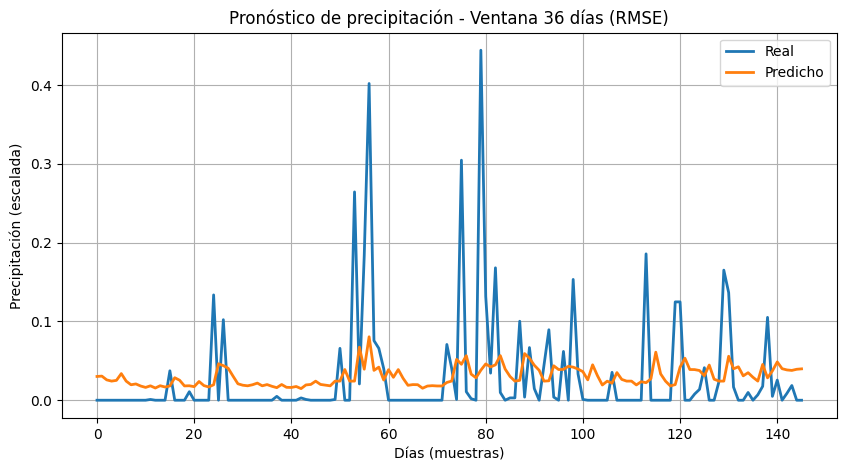

In [122]:
# ===============================================================
#  Visualización de resultados
# ===============================================================
# Tabla comparativa
results_df = pd.DataFrame(results)
print("\nComparación de resultados por ventana temporal:")
print(results_df)

best_lookback = results_df.loc[results_df['RMSE'].idxmin(), 'Lookback']
pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días (RMSE)')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()


Primeras 10 comparaciones de valores reales vs predichos:


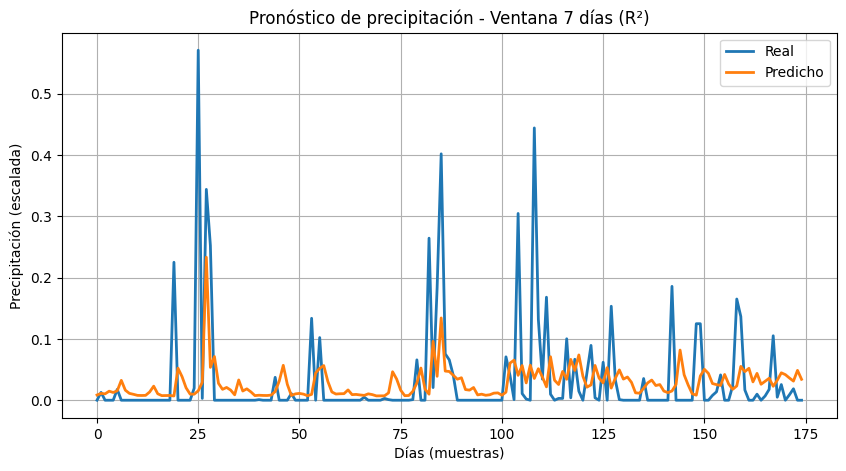

In [125]:
best_lookback = results_df.loc[results_df['R²'].idxmax(), 'Lookback']
pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días (R²)')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

In [124]:
pred_df

,Real,Predicho
0,0.000000,0.030148
1,0.000000,0.030595
2,0.000000,0.025801
3,0.000000,0.024248
4,0.000000,0.025175
...,...,...
141,0.000000,0.039985
142,0.008841,0.038420
143,0.018664,0.037811
144,0.000000,0.039261


## Modelo 4

In [110]:
target_col = 'precipitation'
features_cols = [
    'avg_rel_humidity', 'avg_temp', 'evapotranspiration',
    'max_rel_humidity', 'max_temp', 'min_rel_humidity',
    'min_temp', 'solar_radiation'
]
lookbacks_to_test = [5, 6, 7, 14, 21, 24, 30, 36]

PARAMS = {
    'units': 128,
    'lr': 0.01,           # Alta Tasa de Aprendizaje
    'batch_size': 16,
    'epochs': 100,        # Permitir más épocas
    'drop_rate': 0.2,
    'loss_func': 'mse',   # Pérdida Cuadrática Fuerte
    'patience': 15        # Más paciencia para Early Stopping
}

In [111]:
def train_rnn(
    X_train, y_train, X_val, y_val,
    n_steps, n_features,
    units=128,              # Capacidad Alta
    lr=0.01,                # <--- MÁXIMA TASA DE APRENDIZAJE
    batch_size=16,
    epochs=100,             # Más épocas
    drop_rate=0.2,
    loss_func='mse',        # <--- PÉRDIDA MSE para castigo fuerte
    # huber_delta ya no es necesario aquí, pero se mantiene para flexibilidad si cambias loss
    huber_delta=1.0,
    patience=15,            # Más paciencia para Early Stopping
    verbose=0):

    # --- Definición del modelo SimpleRNN APILADO ---
    model = Sequential([

        # 1. Primera Capa SimpleRNN (permite apilamiento)
        SimpleRNN(units,
                  activation='relu',
                  input_shape=(n_steps, n_features),
                  return_sequences=True),

        # 2. Segunda Capa SimpleRNN (la última capa recurrente)
        SimpleRNN(units // 2,
                  activation='relu'),

        # Dropout
        Dropout(drop_rate),

        # Capa Densa Intermedia
        Dense(32, activation='relu'),

        # Capa de Salida (Regresión con salida lineal)
        Dense(1, activation='linear')
    ])

    # --- Configuración de la Pérdida ---
    if loss_func.lower() == 'huber':
        # Usa Huber si se especifica, permitiendo ajustar el Delta
        loss_to_use = Huber(delta=huber_delta)
    else:
        # Usa MSE, MAE, etc. (se recomienda 'mse' para esta prueba)
        loss_to_use = loss_func

    # 2. Compilación del modelo
    optimizer = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss=loss_to_use,
        metrics=['mae', 'mse'])

    # --- Callbacks: Monitoreando 'val_mae' ---

    # ModelCheckpoint: Guarda el modelo que tenga el MÍNIMO Error Absoluto Medio
    checkpoint = ModelCheckpoint(
        f'best_rnn_model_lb{n_steps}_mae.keras', # Nombre de archivo dinámico
        monitor='val_mae', # <--- CAMBIO: Monitorear MAE
        save_best_only=True,
        mode='min')

    # EarlyStopping: Detiene el entrenamiento si el MAE de validación no mejora
    early_stop = EarlyStopping(
        monitor='val_mae', # <--- CAMBIO: Monitorear MAE
        patience=patience,
        restore_best_weights=True)

    # --- Entrenamiento ---

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint],
        verbose=verbose
        )

    # --- Evaluación ---
    y_pred = model.predict(X_val, verbose=0)

    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)

    return mse, mae, rmse, r2, history, y_pred

In [112]:
# BUCLE DE ENTRENAMIENTO Y EVALUACIÓN ===
print(f"Iniciando entrenamiento con el modelo SimpleRNN Apilado (lr={PARAMS['lr']}, loss={PARAMS['loss_func']})")
print("=========================================================================")

for n_steps in lookbacks_to_test:
    print(f"\nEntrenando con lookback = {n_steps} días...")

    # 1. Preparar los datos para el lookback actual
    try:
        X_train, y_train, X_val, y_val, scaler, _, _ = preparar_datos_modelo(
            df_imputado, # <-- Usa tu DataFrame cargado aquí
            features=features_cols,
            target_col=target_col,
            n_steps=n_steps
            # Usar rangos de fechas por defecto
        )
    except Exception as e:
        print(f"Error al preparar datos para lookback {n_steps}: {e}")
        continue

    # 2. Obtener dimensiones para el modelo
    n_features = X_train.shape[2]

    # 3. Entrenar el modelo con los parámetros de máximo esfuerzo
    try:
        mse, mae, rmse, r2, history, y_pred = train_rnn(
            X_train, y_train, X_val, y_val,
            n_steps, n_features,
            units=PARAMS['units'],
            lr=PARAMS['lr'],
            batch_size=PARAMS['batch_size'],
            epochs=PARAMS['epochs'],
            drop_rate=PARAMS['drop_rate'],
            loss_func=PARAMS['loss_func'],
            patience=PARAMS['patience'],
            verbose=0 # Silenciar el output del entrenamiento
        )

        # 4. Almacenar resultados
        results.append({
            'Lookback': n_steps,
            'MSE': mse,
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2
        })

        print(f"{n_steps} →→ RMSE={rmse:.6f}, MSE={mse:.6f}, MAE={mae:.6f}, R²={r2:.4f}")

    except Exception as e:
        print(f"Error al entrenar para lookback {n_steps}: {e}")


Iniciando entrenamiento con el modelo SimpleRNN Apilado (lr=0.01, loss=mse)

Entrenando con lookback = 5 días...
Ventana: 5
Entrenamiento: (8745, 5, 9), (8745,)
Validación:   (177, 5, 9), (177,)
5 →→ RMSE=0.085347, MSE=0.007284, MAE=0.036443, R²=-0.0657

Entrenando con lookback = 6 días...
Ventana: 6
Entrenamiento: (8744, 6, 9), (8744,)
Validación:   (176, 6, 9), (176,)
6 →→ RMSE=0.083524, MSE=0.006976, MAE=0.037528, R²=-0.0157

Entrenando con lookback = 7 días...
Ventana: 7
Entrenamiento: (8743, 7, 9), (8743,)
Validación:   (175, 7, 9), (175,)
7 →→ RMSE=0.085197, MSE=0.007258, MAE=0.034800, R²=-0.0517

Entrenando con lookback = 14 días...
Ventana: 14
Entrenamiento: (8736, 14, 9), (8736,)
Validación:   (168, 14, 9), (168,)
14 →→ RMSE=0.087336, MSE=0.007628, MAE=0.038312, R²=-0.0665

Entrenando con lookback = 21 días...
Ventana: 21
Entrenamiento: (8729, 21, 9), (8729,)
Validación:   (161, 21, 9), (161,)
21 →→ RMSE=0.089128, MSE=0.007944, MAE=0.038920, R²=-0.0719

Entrenando con lookback


Comparación de resultados por ventana temporal:
   Lookback       MSE       MAE      RMSE  R²        R2
0         5  0.007284  0.036443  0.085347 NaN -0.065653
1         6  0.006976  0.037528  0.083524 NaN -0.015737
2         7  0.007258  0.034800  0.085197 NaN -0.051742
3        14  0.007628  0.038312  0.087336 NaN -0.066496
4        21  0.007944  0.038920  0.089128 NaN -0.071922
5        24  0.008217  0.039002  0.090650 NaN -0.091681
6        30  0.008128  0.039661  0.090157 NaN -0.077029
7        36  0.004993  0.036259  0.070662 NaN -0.026150

 Mejor modelo: Lookback = 36 días

Primeras 10 comparaciones de valores reales vs predichos:
   Real  Predicho
0   0.0  0.037632
1   0.0  0.014080
2   0.0  0.018815
3   0.0  0.014915
4   0.0  0.015888
5   0.0  0.017621
6   0.0  0.021901
7   0.0  0.012022
8   0.0  0.012092
9   0.0  0.005710


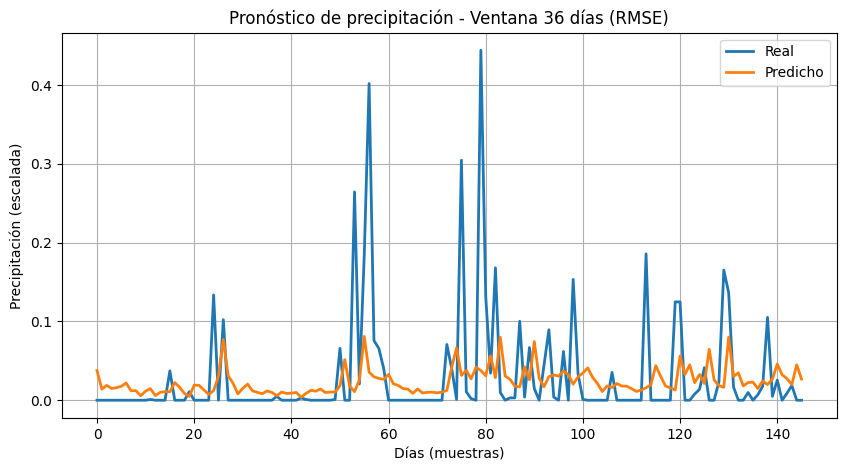

In [118]:
# ==============================
# Comparar predicciones del mejor modelo
# ==============================
# Tabla comparativa
results_df = pd.DataFrame(results)
results_df = results_df.iloc[8:].reset_index(drop=True)

print("\nComparación de resultados por ventana temporal:")
print(results_df)

best_lookback = results_df.loc[results_df['RMSE'].idxmin(), 'Lookback']
print(f"\n Mejor modelo: Lookback = {best_lookback} días")

pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
print(pred_df.head(10))

plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días (RMSE)')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()


 Mejor modelo: Lookback = 6 días R²

Primeras 10 comparaciones de valores reales vs predichos:
       Real  Predicho
0  0.000000  0.010260
1  0.000000  0.011619
2  0.012770  0.013317
3  0.000000  0.016055
4  0.000000  0.014289
5  0.000000  0.012568
6  0.017682  0.015633
7  0.000000  0.023661
8  0.000000  0.013826
9  0.000000  0.010008


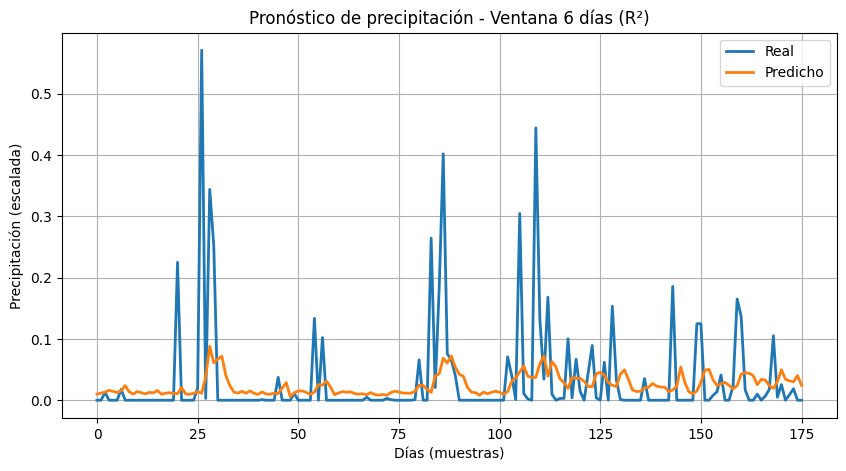

In [117]:
# ==============================
# Comparar predicciones del mejor modelo
# ==============================
best_lookback = results_df.loc[results_df['R2'].idxmax(), 'Lookback']
print(f"\n Mejor modelo: Lookback = {best_lookback} días R²")

pred_df = predictions_dict[best_lookback]
print("\nPrimeras 10 comparaciones de valores reales vs predichos:")
print(pred_df.head(10))

plt.figure(figsize=(10,5))
plt.plot(pred_df['Real'].values[:200], label='Real', linewidth=2)
plt.plot(pred_df['Predicho'].values[:200], label='Predicho', linewidth=2)
plt.title(f'Pronóstico de precipitación - Ventana {best_lookback} días (R²)')
plt.xlabel('Días (muestras)')
plt.ylabel('Precipitación (escalada)')
plt.legend()
plt.grid(True)
plt.show()

## Conclusion

De los diferentes modelos entrenados con modificaciones en su arquitectura y parametros, se observa que los mejores son los que tienen mas de una capa o los siguientes patrones de comportamiento:

 **Arquitectura**

* **Los modelos con más de una capa RNN** (por ejemplo, 2 o 3 capas `SimpleRNN`) presentaron mejores resultados en términos de seguimiento del comportamiento temporal de los datos.
* La configuración de **128 unidades (`units`)** en la primera capa RNN fue la más robusta y consistente en todos los experimentos.

 **Tasa de aprendizaje (`lr`)**

* Para modelos con **función de pérdida MSE**, un `learning rate` de **0.01** resultó efectivo cuando se entrenó con más épocas y una mayor paciencia (`patience`), permitiendo una mejor convergencia.
* Para modelos con **función de pérdida Huber**, los valores de **`lr` = 0.005** y **0.001** ofrecieron un mejor ajuste, especialmente en predicciones con menor error general.

**Otros hiperparámetros clave**

* **`batch_size` = 16** funcionó bien, especialmente en combinación con tasas de aprendizaje más bajas y entrenamiento más prolongado.
* **`drop_rate` = 0.2** fue suficiente para evitar overfitting sin afectar negativamente la capacidad de aprendizaje.


**Función de pérdida**

* **`loss_func = 'mse'`**: Esta pérdida ofrece el máximo castigo a los errores en los picos, siendo teóricamente la más adecuada para forzar la predicción de valores extremos, aunque el modelo SimpleRNN demostró ser insuficiente para capturar esa magnitud.

 * **`loss_func = 'huber'`**:

  * Muestra mejor capacidad de aprendizaje en entrenamientos de 50 a 70 épocas, proporcionando mayor estabilidad en el entrenamiento.

  * Resultados óptimos se obtuvieron con valores de **`huber_delta` entre 0.15 y 0.3**, ya que esta configuración equilibra la sensibilidad en los ceros con la robustez frente a los picos extremos.

 Sin embargo,  ambas arquitecturas **subestiman la magnitud de los picos altos**, lo que la hace menos ideal para tareas donde esos valores extremos son críticos.



**Hiperparámetros finales seleccionados:**


params = params = {

    'units': 128,
    'lr': 0.001,         
    'batch_size': 16,
    'epochs': 70,
    'drop_rate': 0.2,
    'huber_delta': 0.12,   
    'loss_func': 'huber',
    'patience': 10
    
}



## Modelo entrenado con Feature selecionadas

Se ajusta los variables que ayudan a entrenar al modelo

In [35]:
df_imputado["precipitation_ma5"] = (df_imputado["precipitation"].rolling(window=5, min_periods=1).mean())
df_imputado["precipitation_ma5"] = df_imputado["precipitation_ma5"].round(1)
df_imputado

,min_temp,avg_temp,max_temp,min_rel_humidity,avg_rel_humidity,max_rel_humidity,solar_radiation,evapotranspiration,precipitation,year,precipitation_ma5
date,,,,,,,,,,,
2000-01-01,20.1,23.1,27.5,57.0,77.0,95.0,308.1,2.8,0.0,2000,0.0
2000-01-02,19.2,22.0,26.7,58.0,82.0,98.0,343.1,4.1,0.0,2000,0.0
2000-01-03,18.0,21.7,28.8,51.0,80.0,98.0,456.1,4.5,2.1,2000,0.7
2000-01-04,17.8,21.9,27.1,50.0,74.0,90.0,391.5,3.8,0.0,2000,0.5
2000-01-05,19.0,22.3,27.4,51.0,76.0,95.0,348.4,3.9,0.0,2000,0.4
...,...,...,...,...,...,...,...,...,...,...,...
2024-06-26,19.5,23.0,29.1,58.0,87.0,100.0,358.8,2.9,0.0,2024,3.1
2024-06-27,20.2,22.0,27.9,66.0,92.0,100.0,276.0,2.2,0.9,2024,2.9
2024-06-28,18.8,22.7,28.4,59.0,88.0,100.0,379.5,3.1,1.9,2024,1.2


In [36]:
features = ['min_temp','avg_temp','max_temp',
            'min_rel_humidity','avg_rel_humidity', 'max_rel_humidity',
            'solar_radiation','evapotranspiration',
            'precipitation_ma5']
target = "precipitation"
# Esto se obtiene de X_train.shape[1]
n_steps = X_train.shape[1]
# Esto se obtiene de X_train.shape[2]
n_features = X_train.shape[2]
n_steps = 36

In [37]:
X_train, y_train, X_val, y_val, scaler, train_scaled, val_scaled = preparar_datos_modelo(
    df_imputado,
    features=features,
    target_col=target,
    n_steps=n_steps,
    train_range=('2000-01-01', '2023-12-31'),
    val_range=('2024-01-01', '2024-06-30')
)

Ventana: 36
Entrenamiento: (8714, 36, 10), (8714,)
Validación:   (146, 36, 10), (146,)


In [39]:
params

{'units': 128, 'lr': 0.005, 'batch_size': 16, 'epochs': 50, 'drop_rate': 0.2}

In [40]:
# ===============================================================
# 3. Llamada para iniciar el Entrenamiento
# ===============================================================
print(f"Iniciando entrenamiento del modelo RNN...")
print(f"Configuración: Ventana={n_steps}, Características={n_features}")

mse_result, mae_result, rmse_result, r2_result, history_model, y_pred_val = train_rnn(
    # --- Datos ---
    X_train,
    y_train,
    X_val,
    y_val,

    # --- Parámetros de Shape ---
    n_steps=n_steps,
    n_features=n_features,

    # --- Hiperparámetros
     **params,
    # Si quieres ver el progreso, puedes añadir:
    verbose=1
)

# ===============================================================
# 4. Mostrar Resultados
# ===============================================================
print("\n--- Entrenamiento Finalizado ---")
print("Métricas de Evaluación en el conjunto de Validación:")
print(f"MSE (Error Cuadrático Medio): {mse_result:.4f}")
print(f"MAE (Error Absoluto Medio): {mae_result:.4f}")
print(f"RMSE (Raíz de Error Cuadrático Medio): {rmse_result:.4f}")
print(f"R2 (Coeficiente de Determinación): {r2_result:.4f}")

Iniciando entrenamiento del modelo RNN...
Configuración: Ventana=36, Características=10
Epoch 1/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1118 - mse: 0.0485 - val_loss: 0.0299 - val_mse: 0.0058
Epoch 2/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0325 - mse: 0.0081 - val_loss: 0.0296 - val_mse: 0.0057
Epoch 3/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.0311 - mse: 0.0074 - val_loss: 0.0300 - val_mse: 0.0058
Epoch 4/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0327 - mse: 0.0080 - val_loss: 0.0301 - val_mse: 0.0055
Epoch 5/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0321 - mse: 0.0083 - val_loss: 0.0294 - val_mse: 0.0057
Epoch 6/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.0312 - mse: 0.0076 - val_loss: 0.0299 - val_mse: 0.0056
Epoch 7/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0339 - mse: 0.0083 - val_loss: 0.0297 - val_mse: 0.0056
Epoch 8/50
545/545 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.0322 - mse: 0.0

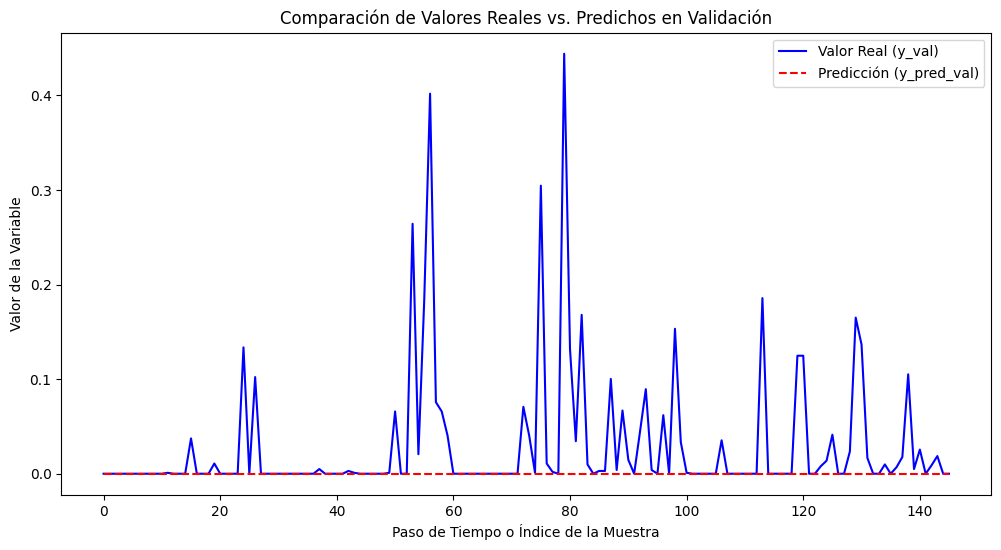

In [43]:
# y_val_flat = y_val.flatten()
# y_pred_val_flat = y_pred_val.flatten()

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_val)), y_val, label='Valor Real (y_val)', color='blue')
plt.plot(np.arange(len(y_pred_val)), y_pred_val, label='Predicción (y_pred_val)', color='red', linestyle='--')
plt.xlabel('Paso de Tiempo o Índice de la Muestra')
plt.ylabel('Valor de la Variable')
plt.title('Comparación de Valores Reales vs. Predichos en Validación')
plt.legend()
plt.show()

In [48]:
y_val[:20]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00098232, 0.        , 0.        , 0.        ,
       0.03732809, 0.        , 0.        , 0.        , 0.0108055 ])

In [49]:
y_pred_val[:20]

array([[1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05],
       [1.03831335e-05]], dtype=float32)